# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2022/23 (6 CFU) - Dr. Jacopo Pegoraro, Dr. Daniele Mari
---


## Lab. 06 - Convolutional Autoencoder

An autoencoder, in general, is a network that is trained to attempt to copy its input to its output. Internally, it has a **latent space** that describes a code used to represent the input. The network may be viewed as consisting of two parts: an **encoder** function $h=f(x)$ and a **decoder** that produces a reconstruction $r=g(h)$.

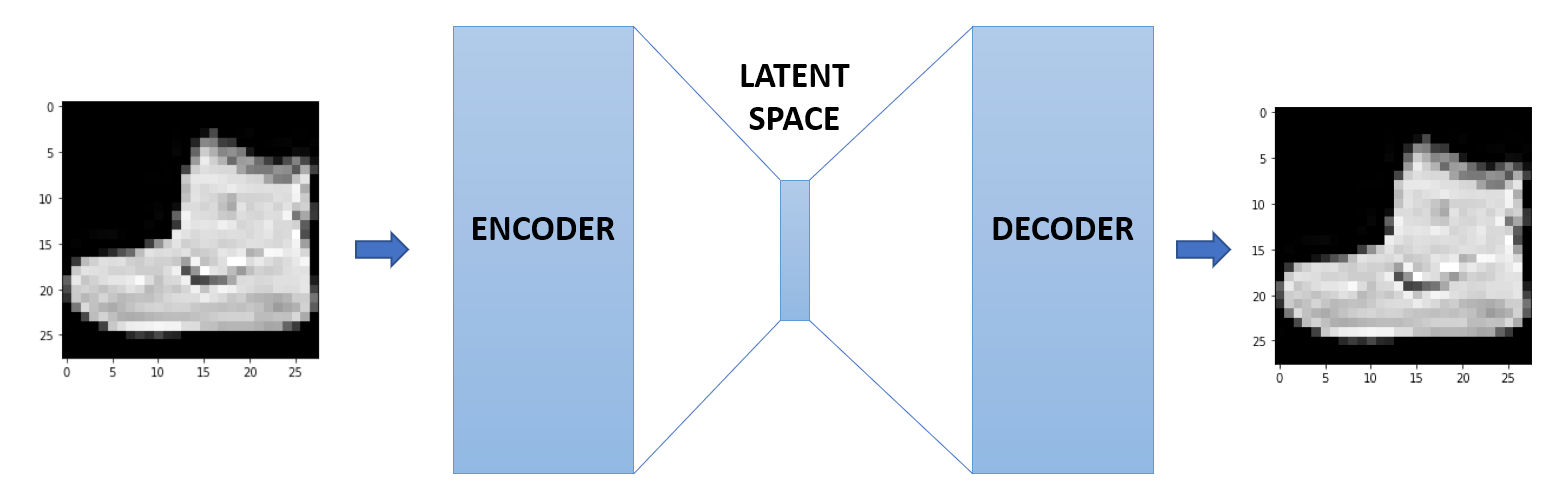

The learning process is described simply as minimizing a loss function $L(x, g(f(x)))$, where $L$ is a loss function penalizing $g(f(x))$ for being dissimilar from $x$, such as the mean squared error.

While the learning is considered to be **unsupervised** since we are using only the value of $x$, the actual implementation is similar to a supervised setting where the label is just derived from the input.

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

# Dataset

## Define the dataset

For this lab. we will use one of the datasets already included in PyTorch ([https://pytorch.org/vision/stable/datasets.html](https://pytorch.org/vision/stable/datasets.html)).

**NOTE:** These datasets do not require the definition of a custom `Dataset` class, so we can focus on the network implementation.

The Fashion MNIST dataset is a colletion of Zalando's article images. The size of the images is $28 \times 28$, and there is a single channel only (black and white images) with 10 classes.

In [2]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



The output of the dataset is a PIL Image, a standard format for image processing, but we can easily convert the data to a NumPy array:
```
image_numpy = np.array(pil_image)
```
or to a PyTorch tensor:
```
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(pil_image)
```


Let's plot some random samples from the dataset. The first element of the sample is the actual image, while the second is the corresponding label.

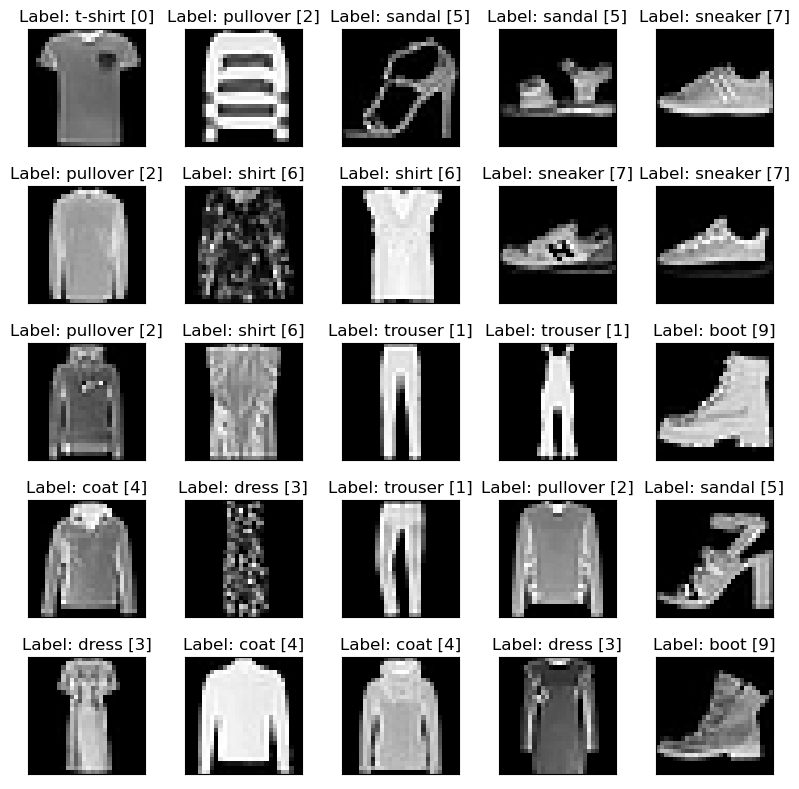

In [3]:
### Plot some samples
label_names = ['t-shirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','boot']
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Define the dataset transform

In this example we are using the input images without any modification. As always, the only requirement is to transform the input data to tensors of the proper shape.

In [4]:
# In this case the train_transform and test_transform are the same, but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

Since we already defined our datasets, this is an alternative (and recommended) way to add (or modify) a dataset transformation without reinitializing the dataset (very useful when the dataset initialization is slow):

In [5]:
# check what is going on BEFORE the transformation is in place!
print(train_dataset)
print(train_dataset[0])
print(train_dataset[0][0])
print(train_dataset[0][1])

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: dataset
    Split: Train
(<PIL.Image.Image image mode=L size=28x28 at 0x7FA577345070>, 9)
<PIL.Image.Image image mode=L size=28x28 at 0x7FA5A4FB6D90>
9


In [6]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [7]:
# check what is going on AFTER the transformation is in place!
print(train_dataset)
print(train_dataset[0])
print(train_dataset[0][0])
print(train_dataset[0][1])

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: dataset
    Split: Train
(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000,

## Define the dataloader

The dataloader allows to easily create batch of data, in this case we set a batch size of 256, and we also enable data shuffling for the training dataset.

In [8]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


# Autoencoder

## Encoder

Let's start from the encoder. In the figure you can find a suggested architecture for the encoder, with all the required parameters for each layer.

In this example we are considering a latent space with just **2 variables**, so make sure your encoder generates tensors with the proper shape.

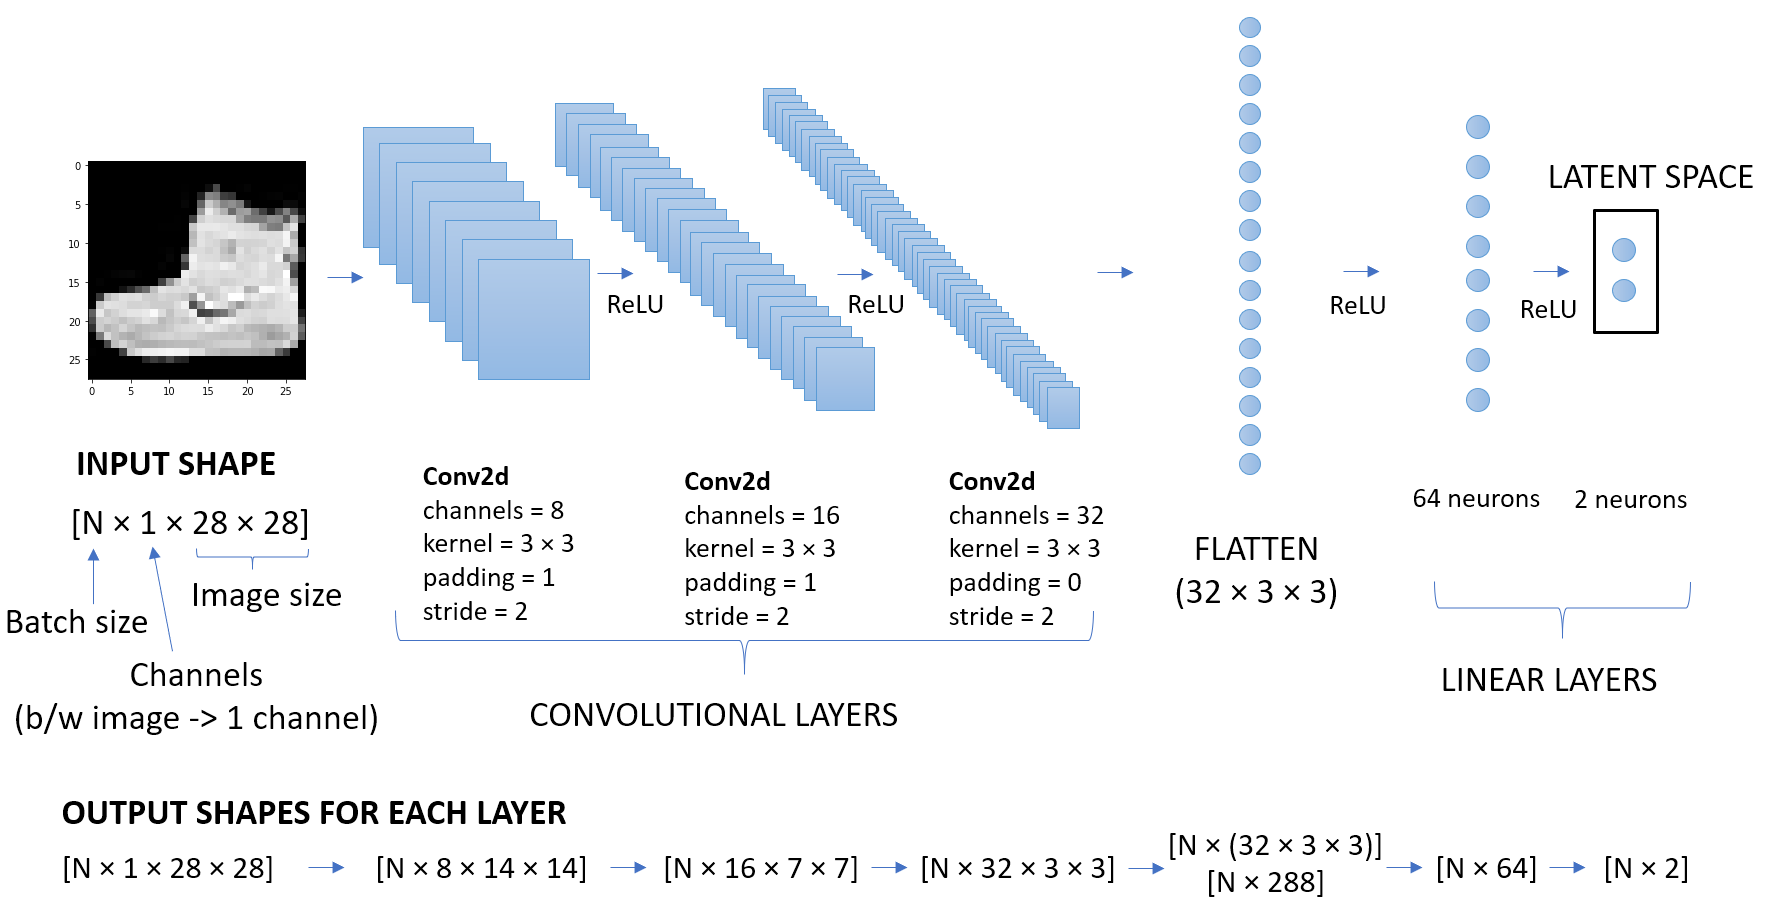

`torch.nn.Sequential` is a utility function that allows to easily concatenate sequential layers, without defining a separate object for each of them (more details here: [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)).

The output of a convolutional layer is typically multi-dimensional. To apply a linear layer after a convolutional one you should convert your tensor to a monodimensional array. This operation is often referred to as **flattening**. In PyTorch, this can be done with the [`torch.nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html?highlight=flatten#torch.nn.Flatten)
 layer. By setting `start_dim = 1` we keep the first axis (index 0) as it is (which represents the batch size in our case, that should not be flattened) and all the other axes will be flattened in the new second axis.


In [9]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=3*3*32, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

## Decoder

Typically the structure of the decoder is specular with respect to the encoder, but this is not a strict requirement. Some successful implementations use very different architectures for the encoder and the decoder. 

The only requirement of the decoder is the input shape, which must match the latent space, and the output shape, that must match the input image. 

In this example we implement a decoder perfectly matched with the encoder architecture, but reversed.

Since the convolutional layers in the encoder perform a down-scaling, we need up-scaling layers in the decoder. To this end we use **transposed convolutions**, already available in PyTorch with the [`torch.nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) layer.

Similarly to the `torch.nn.Flatten` layer, the [`torch.nn.Unflatten`](https://pytorch.org/docs/stable/generated/torch.nn.Unflatten.html?highlight=unflatten#torch.nn.Unflatten) layer does the opposite operation. We take the axis at index 1 (`dim=1`) and we reshape it to the proper shape (`unflattened_size=(32, 3, 3)`).

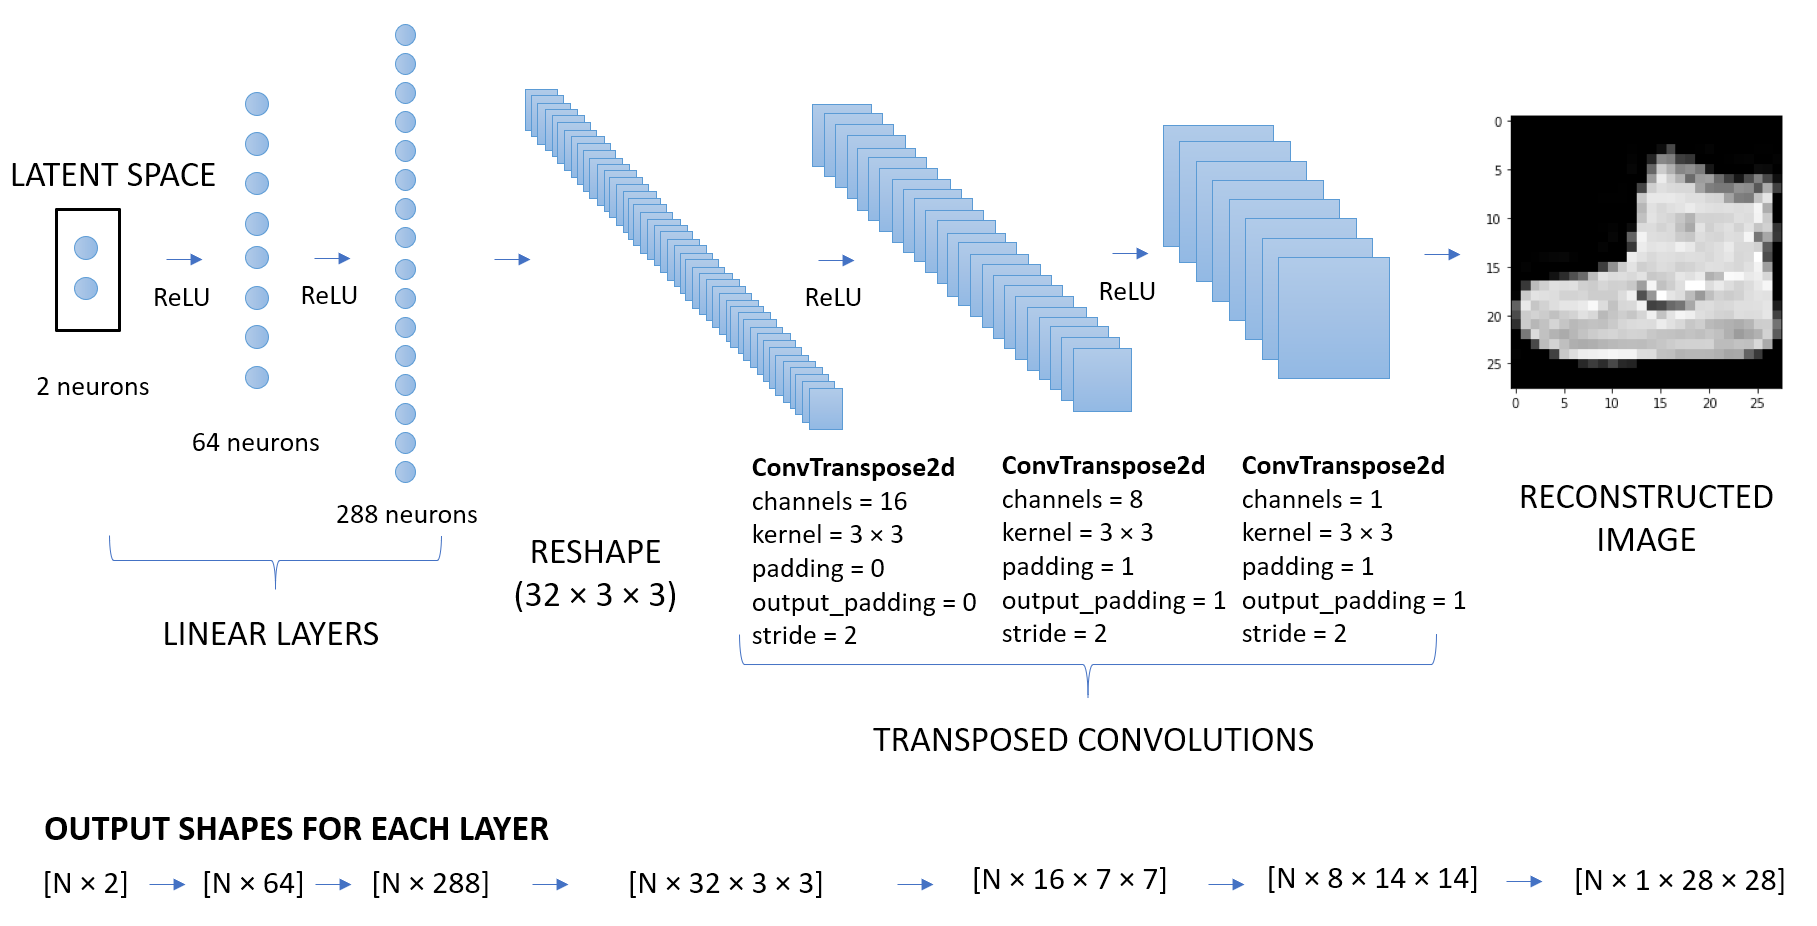

Inputs with different sizes can lead to outputs of the same size.

In [10]:
input_t = torch.ones(1, 3, 5, 5)
conv = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2)
print(f"Input size: {input_t.shape} Output size:{conv(input_t).shape}")

input_t = torch.ones(1, 3, 6, 6)
print(f"Input size: {input_t.shape} Output size:{conv(input_t).shape}")

Input size: torch.Size([1, 3, 5, 5]) Output size:torch.Size([1, 8, 2, 2])
Input size: torch.Size([1, 3, 6, 6]) Output size:torch.Size([1, 8, 2, 2])


In the decoder the correct output size can be obtained by specifying the `output_padding` parameter.

In [11]:
input_t = torch.ones(1, 8, 2, 2)
conv_zero_out_pad = nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3, stride=2, output_padding=0)
print(f"Input size: {input_t.shape} Output size:{conv_zero_out_pad(input_t).shape}")

conv_out_pad = nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3, stride=2, output_padding=1)
print(f"Input size: {input_t.shape} Output size:{conv_out_pad(input_t).shape}")

Input size: torch.Size([1, 8, 2, 2]) Output size:torch.Size([1, 3, 5, 5])
Input size: torch.Size([1, 8, 2, 2]) Output size:torch.Size([1, 3, 6, 6])


In [12]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=3*3*32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

Initialize the two networks.

In [13]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

Let's check if all the shapes are correct.

In [14]:
### Some examples
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image
img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 2])
Decoded image shape: torch.Size([1, 1, 28, 28])


# Training

The training is similar to the previous examples. The only difference is that now we have 2 different networks. In this situation you have 2 choices:
*   Use a single optimizer to train the parameters of both networks.
*   Define a separate optimizer for each network, and update both of them in the training loop.

In this case we define a single optimizer for both networks, by just providing a list of the required parameters to the optimizer (see the code below).

You can find more details for all the possible scenarios [here](https://pytorch.org/docs/stable/optim.html).

In [15]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 5e-4 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

## Training function

For a cleaner and more reusable code, we define a training and a testing function. This will make the training loop more compact and readable.

The function will train (and test) the network just **for a single epoch**.

In this case, we just track the training loss for each batch. If you want the training loss for the entire epoch, you have to concatenate all the outputs (see the testing function as reference for this case).

In [16]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    losses = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.detach().cpu().numpy())
    losses = np.mean(losses)
    return losses

## Testing function

In this case, the testing function has the only goal to evaluate how well we are reproducing the input. We quantify this with the average MSE of the entire test set (which in this case correspond to our loss function, but this is not always true).

Since the entire dataset does not always fit in memory, this example shows how to evaluate the network output in batches, aggregating the results (using `conc_out` and `conc_label` in the code). At the end, you can evaluate a  single overall loss.

In [17]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

## Training loop

Now that we have the training and testing functions, the training loop is considerably simplified. We just need to call these 2 functions for `num_epochs` times.

To see what happens during the training, we also show the output corresponding to a specific image at the end of each epoch.

EPOCH 1/10
TRAIN - EPOCH 1/10 - loss: 0.10404375940561295
VALIDATION - EPOCH 1/10 - loss: 0.05984467640519142



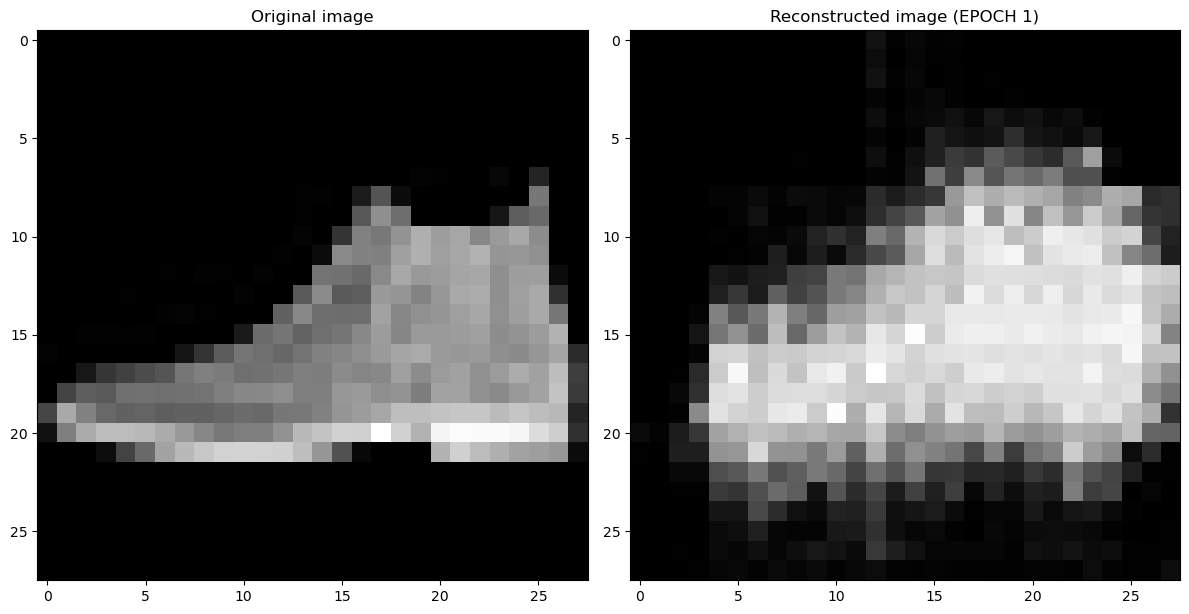

EPOCH 2/10
TRAIN - EPOCH 2/10 - loss: 0.04881400242447853
VALIDATION - EPOCH 2/10 - loss: 0.042143624275922775



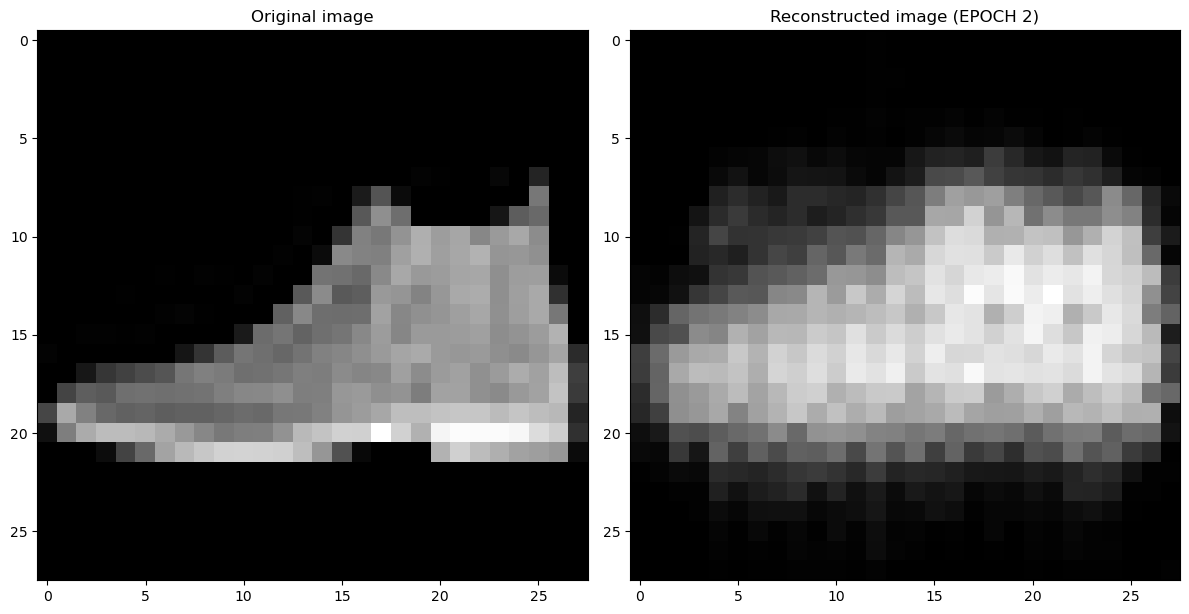

EPOCH 3/10
TRAIN - EPOCH 3/10 - loss: 0.04073546454310417
VALIDATION - EPOCH 3/10 - loss: 0.039226189255714417



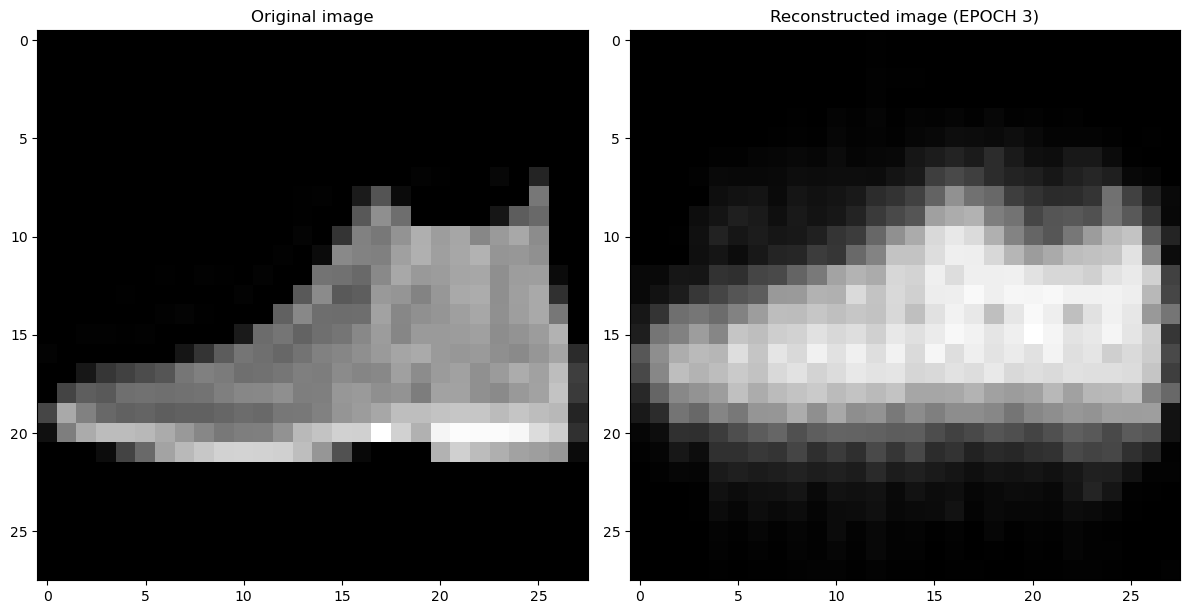

EPOCH 4/10
TRAIN - EPOCH 4/10 - loss: 0.03847835585474968
VALIDATION - EPOCH 4/10 - loss: 0.03741775080561638



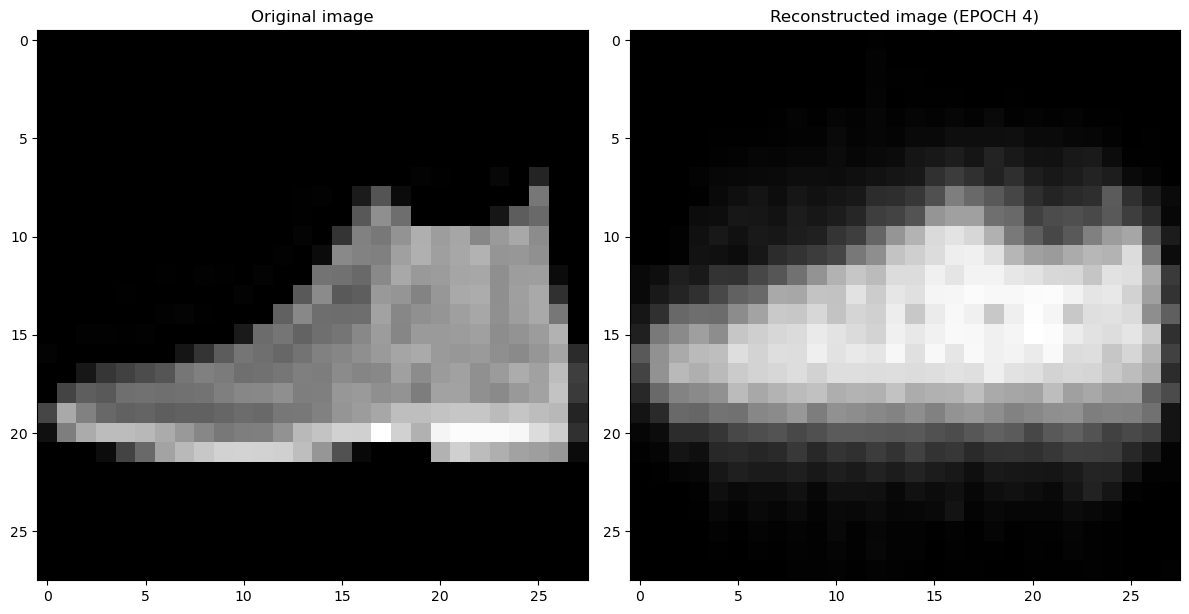

EPOCH 5/10
TRAIN - EPOCH 5/10 - loss: 0.03683234006166458
VALIDATION - EPOCH 5/10 - loss: 0.03591457009315491



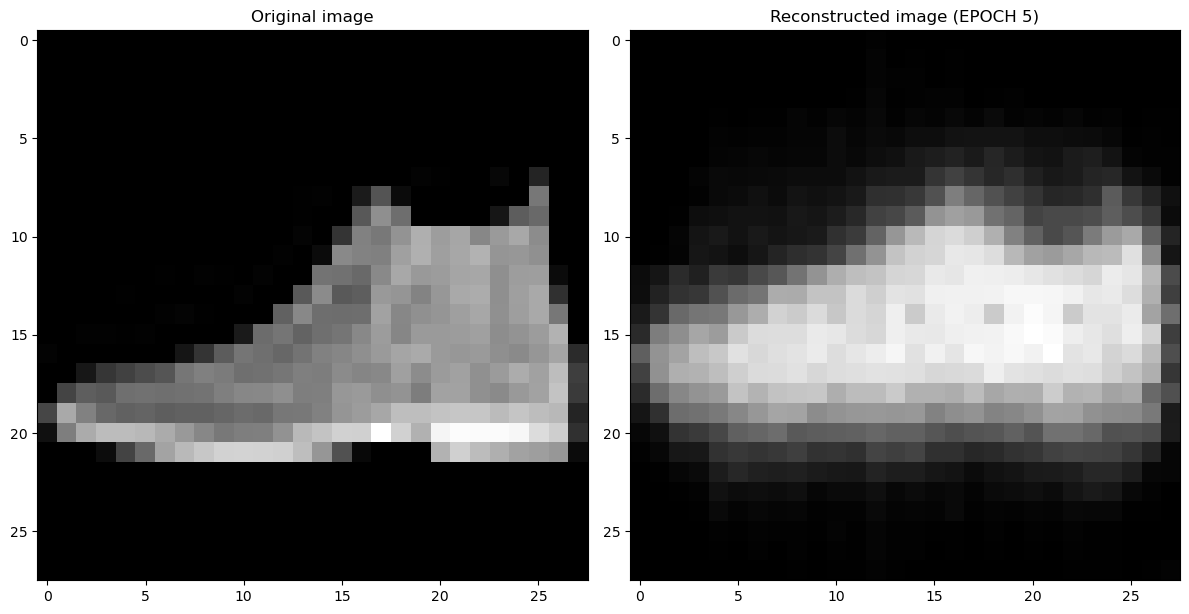

EPOCH 6/10
TRAIN - EPOCH 6/10 - loss: 0.03507682681083679
VALIDATION - EPOCH 6/10 - loss: 0.03421655669808388



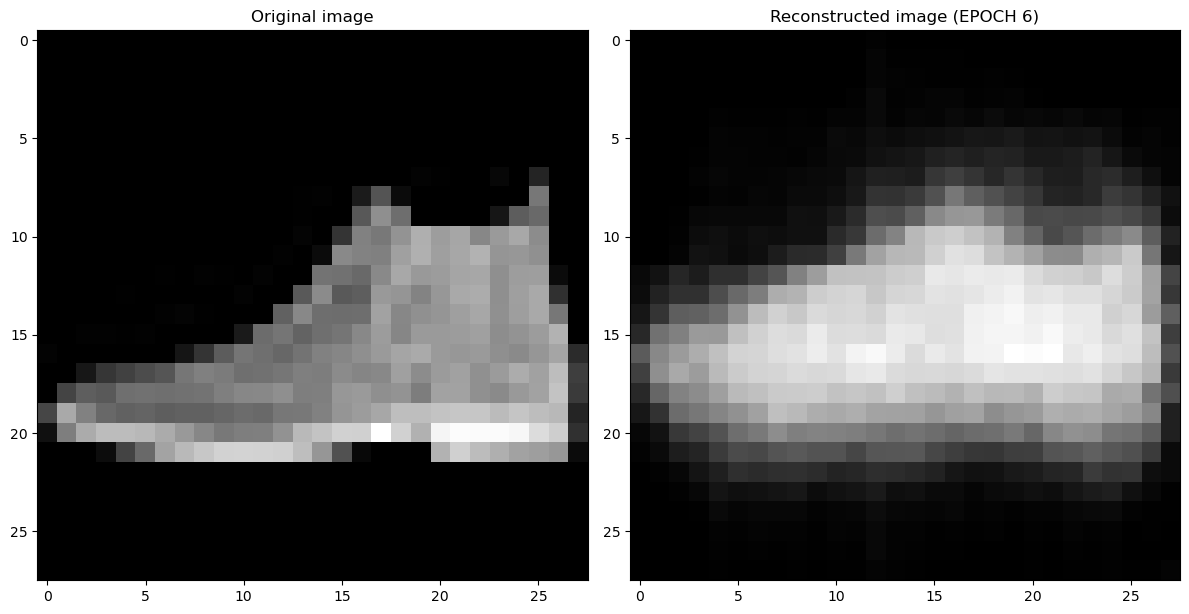

EPOCH 7/10
TRAIN - EPOCH 7/10 - loss: 0.034019071608781815
VALIDATION - EPOCH 7/10 - loss: 0.033515553921461105



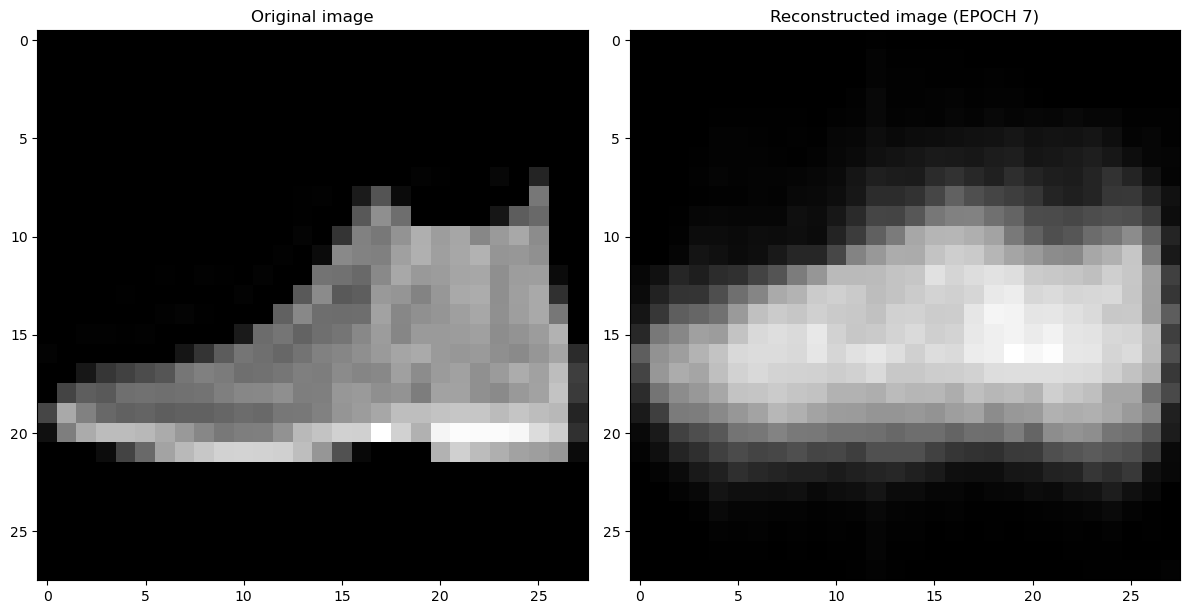

EPOCH 8/10
TRAIN - EPOCH 8/10 - loss: 0.03340482711791992
VALIDATION - EPOCH 8/10 - loss: 0.03292999789118767



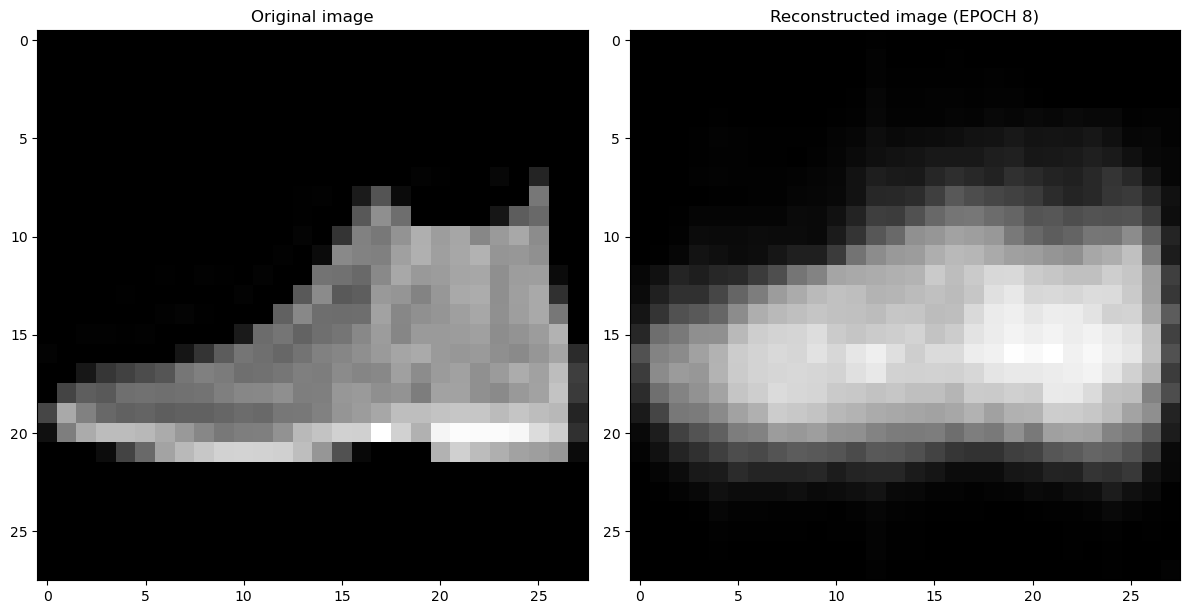

EPOCH 9/10
TRAIN - EPOCH 9/10 - loss: 0.032916340976953506
VALIDATION - EPOCH 9/10 - loss: 0.03252995386719704



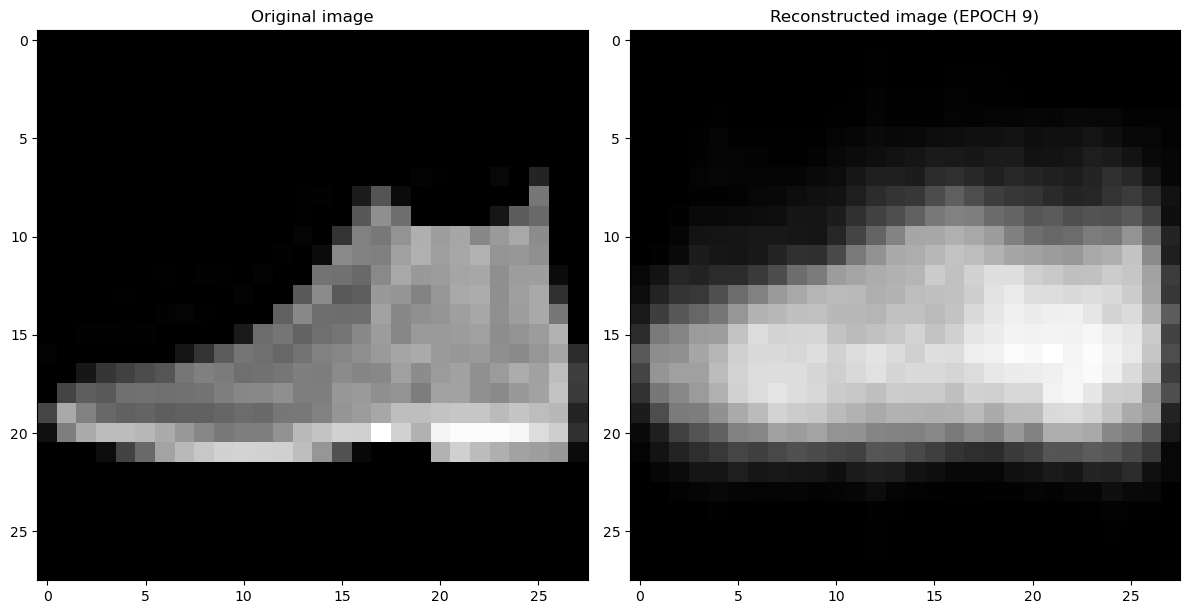

EPOCH 10/10
TRAIN - EPOCH 10/10 - loss: 0.03254382312297821
VALIDATION - EPOCH 10/10 - loss: 0.032169610261917114



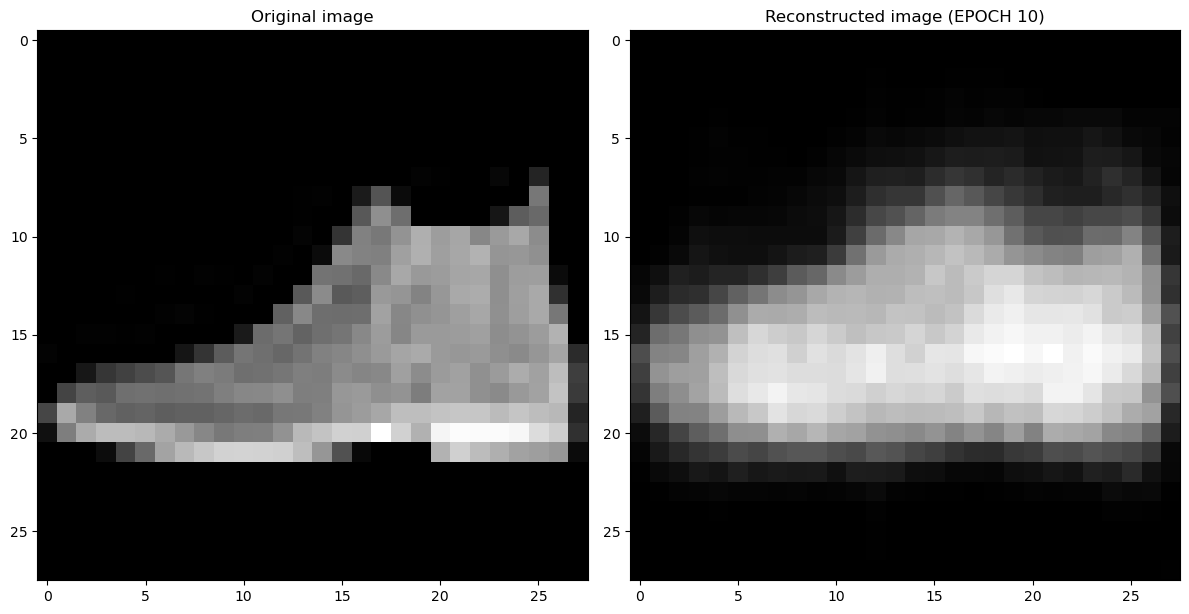

In [18]:
### Training cycle
num_epochs = 10
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    print(f'TRAIN - EPOCH {epoch+1}/{num_epochs} - loss: {train_loss}')

    ### Validation (use the testing function)
    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    # Print Validation loss
    print(f'VALIDATION - EPOCH {epoch+1}/{num_epochs} - loss: {val_loss}\n')

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[0][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img = decoder(encoder(img))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

    # Save network parameters
    torch.save(encoder.state_dict(), 'encoder_params.pth')
    torch.save(decoder.state_dict(), 'decoder_params.pth')

    # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training

# Network Analysis

If you have a previously saved network, restore the network parameters.

In [19]:
# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))

<All keys matched successfully>

The encoder can be used to evaluate the latent space values for each of the test images. Since we used an encoded space dimension of 2, the encoder maps an entire image to just 2 floating point numbers.

We also save the corresponding label to show how each digit is mapped in the encoded space.

In [20]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:05<00:00, 1868.44it/s]


For convenience (not required), convert the result to a table format (`pandas.DataFrame`):

In [21]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

Enc. Variable 0  Enc. Variable 1  label
0           -4.485139       -17.072956      9
1            2.631442        10.947173      2
2          -32.829449         8.152806      1
3          -37.409431         4.504198      1
4           -3.526350        -0.794268      6
...               ...              ...    ...
9995        12.044807       -15.550488      9
9996       -31.141300        -0.614758      1
9997        -9.100802        -0.358115      8
9998       -42.998238         6.087414      1
9999        -6.024009       -16.086746      5

[10000 rows x 3 columns]

This graph shows where each input image is mapped in the encoded space. Since we have just 2 encoded variables, we can easily plot them in a bidimensional space. 

In [22]:
import plotly.express as px
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)

As you can see from the graph, even if we never used the labels (i.e. the id of the class in the image) during the training, the network has been able to clusterize quite well the different classes.

> **NOTE**
> 
> The encoded space may have many more variables. In this case you can still have a visual representation of the encoded space by applying a dimensionality reduction method, such as:
- [Principal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [t-distributed Stochastic Neighbor Embedding (t-SNE)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)




While the encoder is able to map the image to the encoded space, the decoder can do the opposite, generating an image given the corresponding latent space values.

The latent space can also be manually customized, like in the following example, where we generate images with the decoder by providing custom latent space variables.

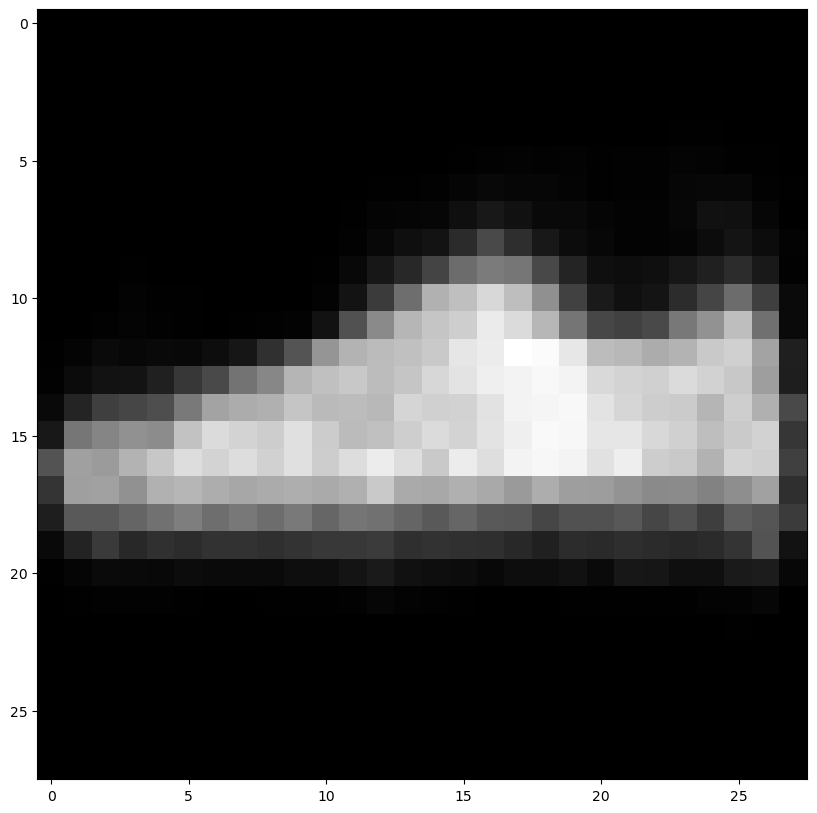

In [23]:
if encoded_space_dim == 2:
    # Generate a custom sample
    custom_encoded_sample = [-6, -30.0]
    encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

    # Decode sample
    decoder.eval()
    with torch.no_grad():
        generated_img  = decoder(encoded_value)

    plt.figure(figsize=(12,10))
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
    plt.show()

# Further insights on PCA and t-SNE

Let's do the same training again, with encoded dimension equal to 10.

Selected device: cpu
EPOCH 1/10
TRAIN - EPOCH 1/10 - loss: 0.100194551050663

VALIDATION - EPOCH 1/10 - loss: 0.049442920833826065



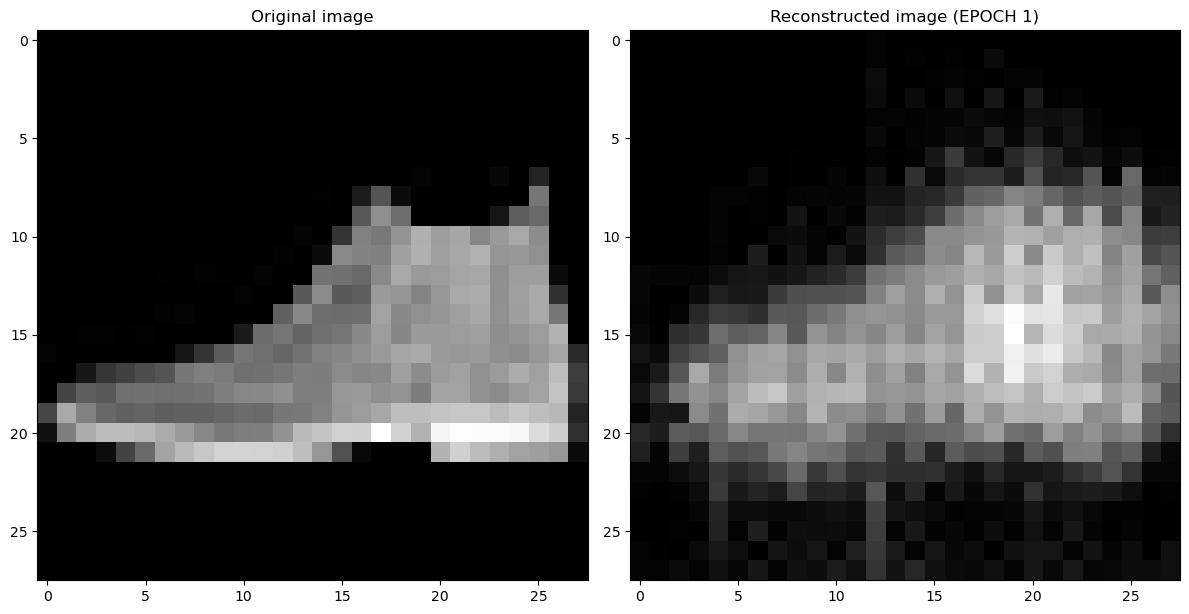

EPOCH 2/10
TRAIN - EPOCH 2/10 - loss: 0.03926843777298927

VALIDATION - EPOCH 2/10 - loss: 0.03110904060304165



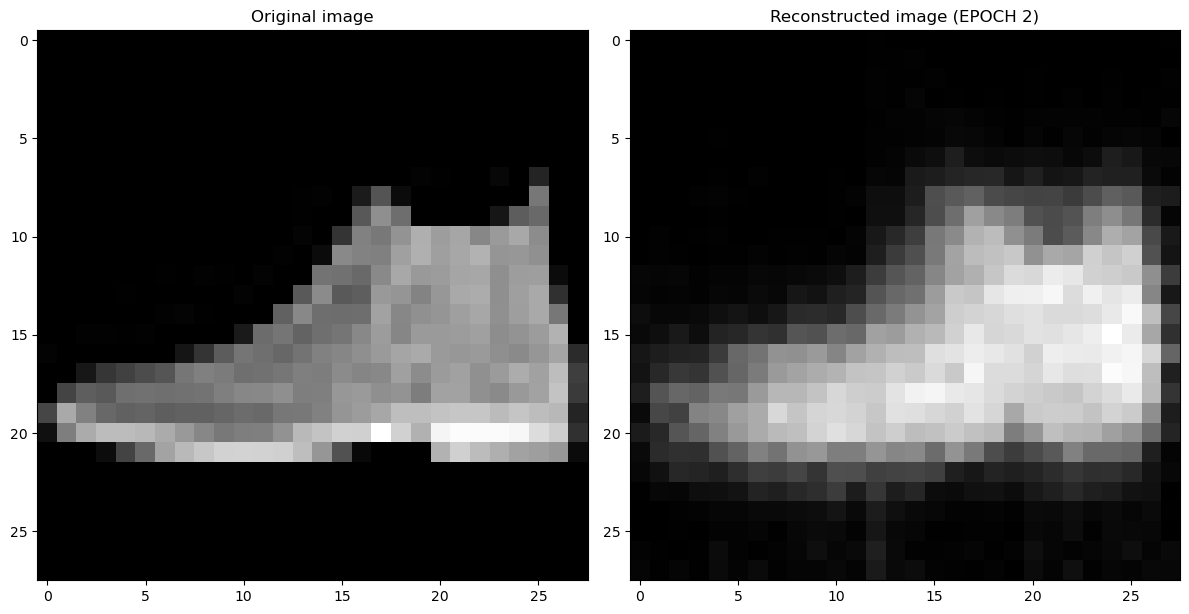

EPOCH 3/10
TRAIN - EPOCH 3/10 - loss: 0.028328314423561096

VALIDATION - EPOCH 3/10 - loss: 0.02620735578238964



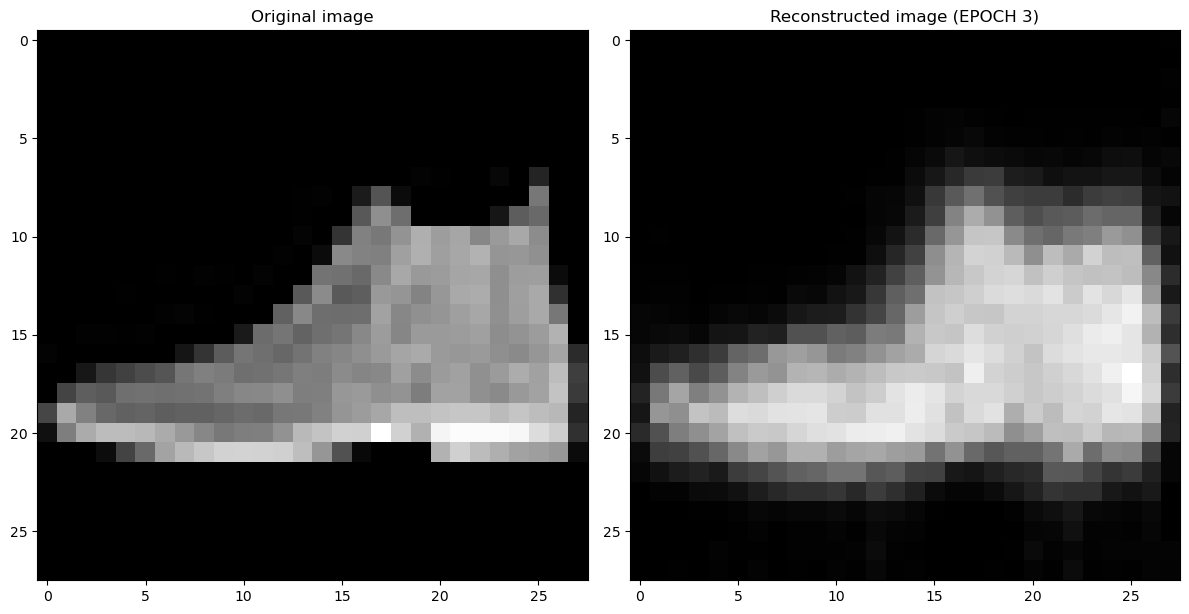

EPOCH 4/10
TRAIN - EPOCH 4/10 - loss: 0.025199204683303833

VALIDATION - EPOCH 4/10 - loss: 0.024497510865330696



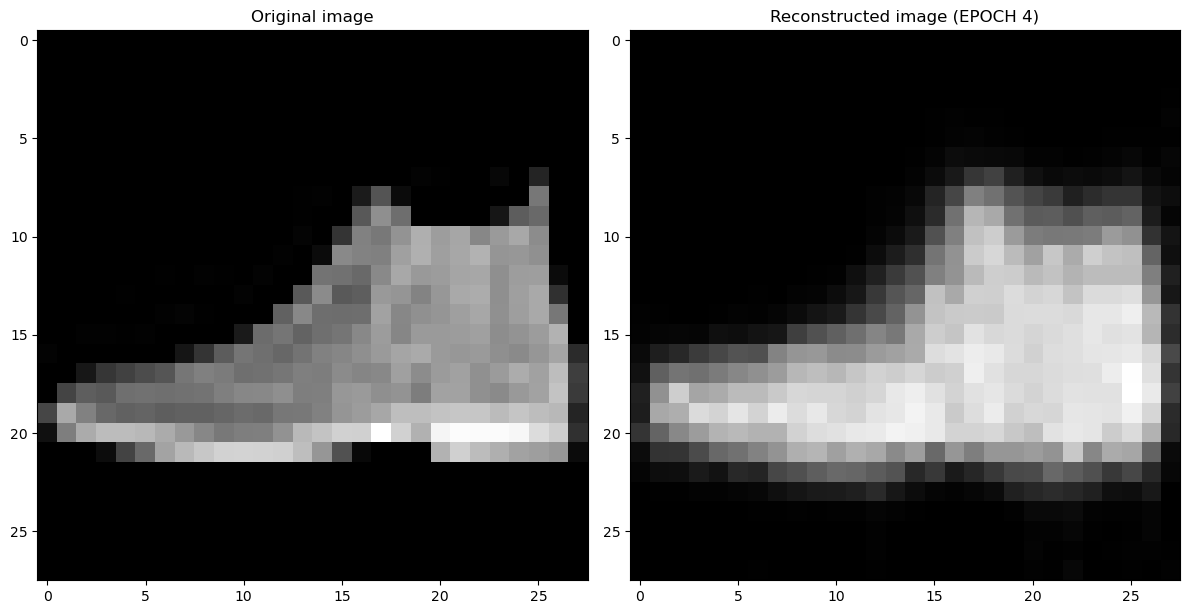

EPOCH 5/10
TRAIN - EPOCH 5/10 - loss: 0.023837143555283546

VALIDATION - EPOCH 5/10 - loss: 0.02347562462091446



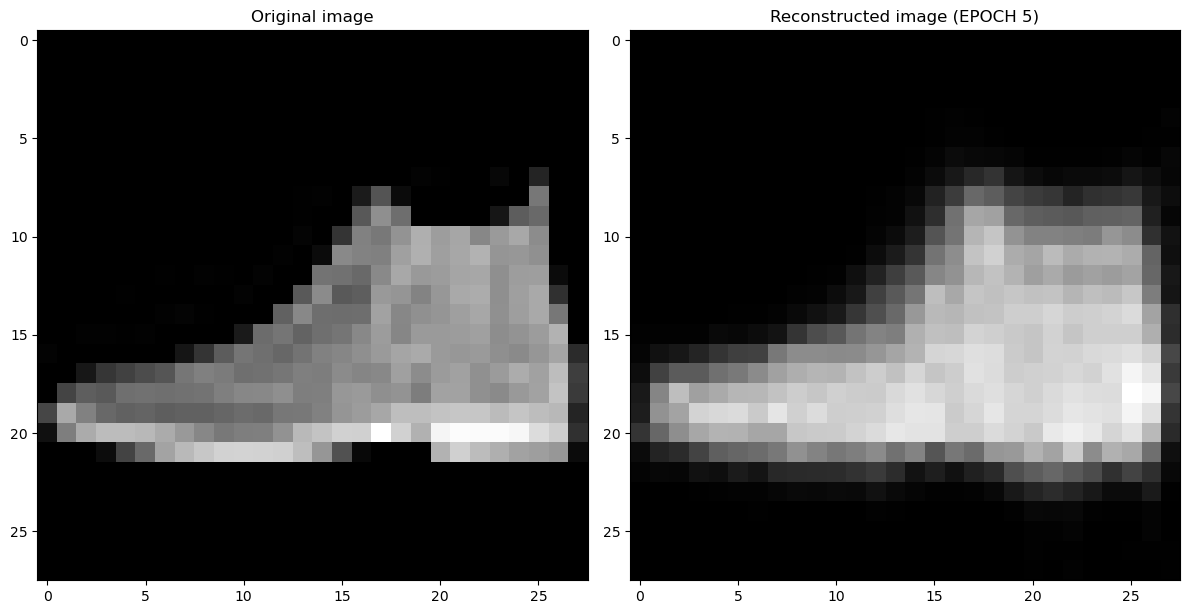

EPOCH 6/10
TRAIN - EPOCH 6/10 - loss: 0.02288813330233097

VALIDATION - EPOCH 6/10 - loss: 0.022617032751441002



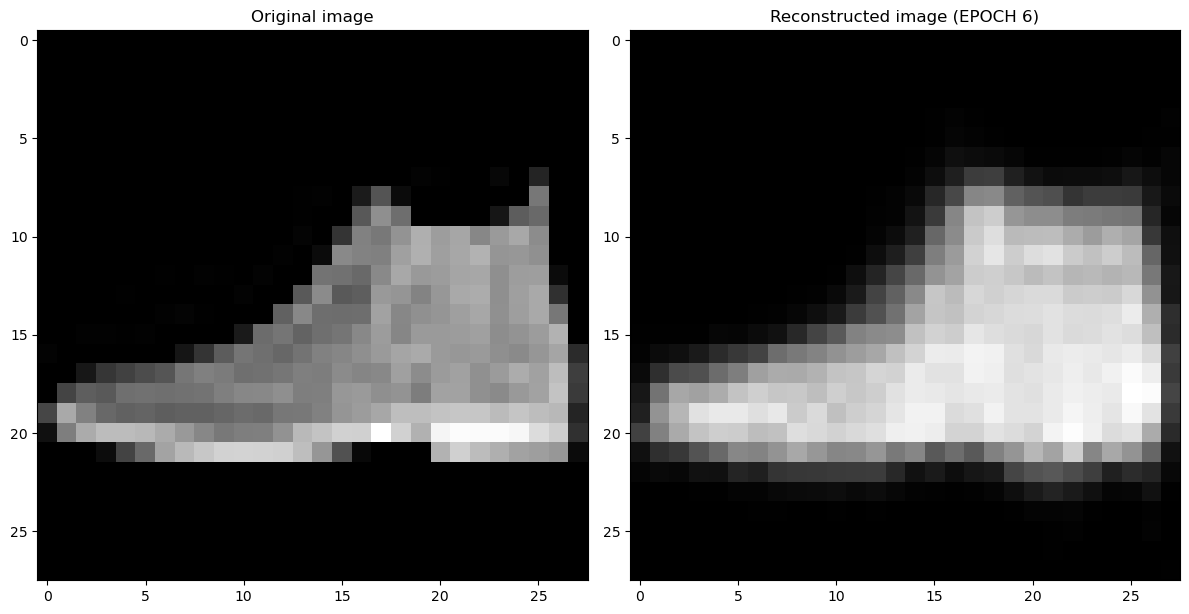

EPOCH 7/10
TRAIN - EPOCH 7/10 - loss: 0.02200491540133953

VALIDATION - EPOCH 7/10 - loss: 0.02173185534775257



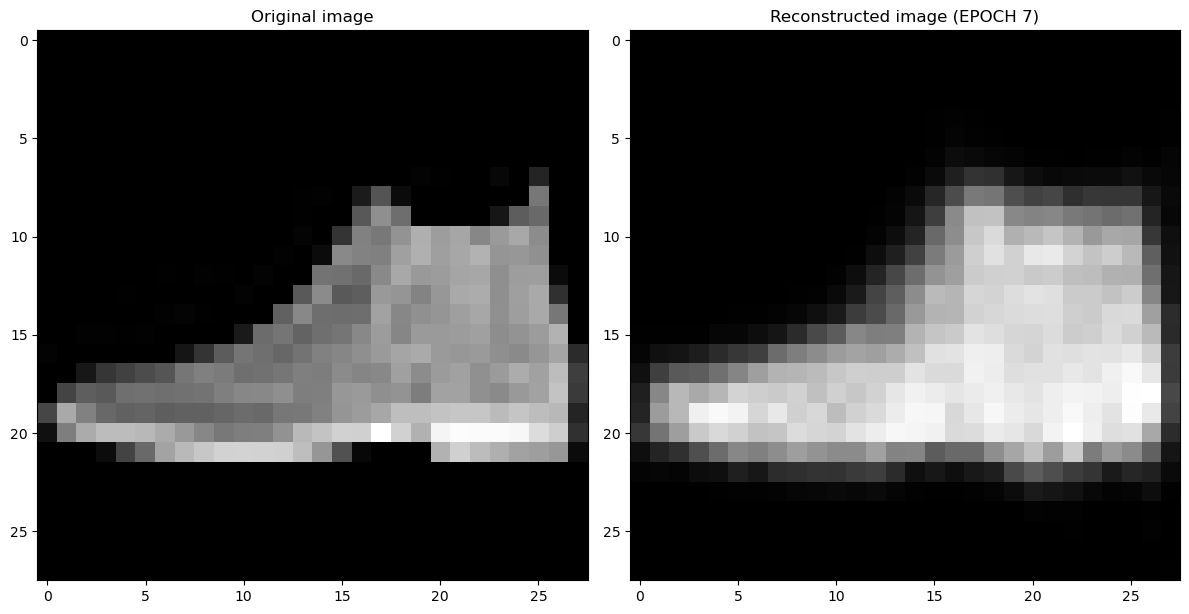

EPOCH 8/10
TRAIN - EPOCH 8/10 - loss: 0.02127259038388729

VALIDATION - EPOCH 8/10 - loss: 0.02112981677055359



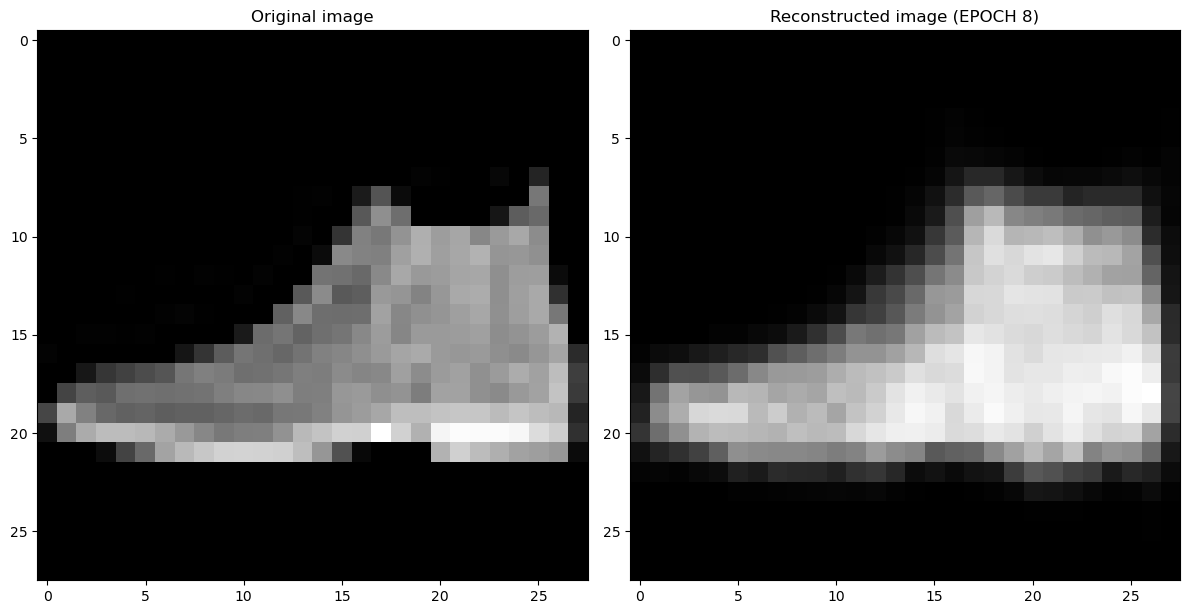

EPOCH 9/10
TRAIN - EPOCH 9/10 - loss: 0.02085200697183609

VALIDATION - EPOCH 9/10 - loss: 0.020812055096030235



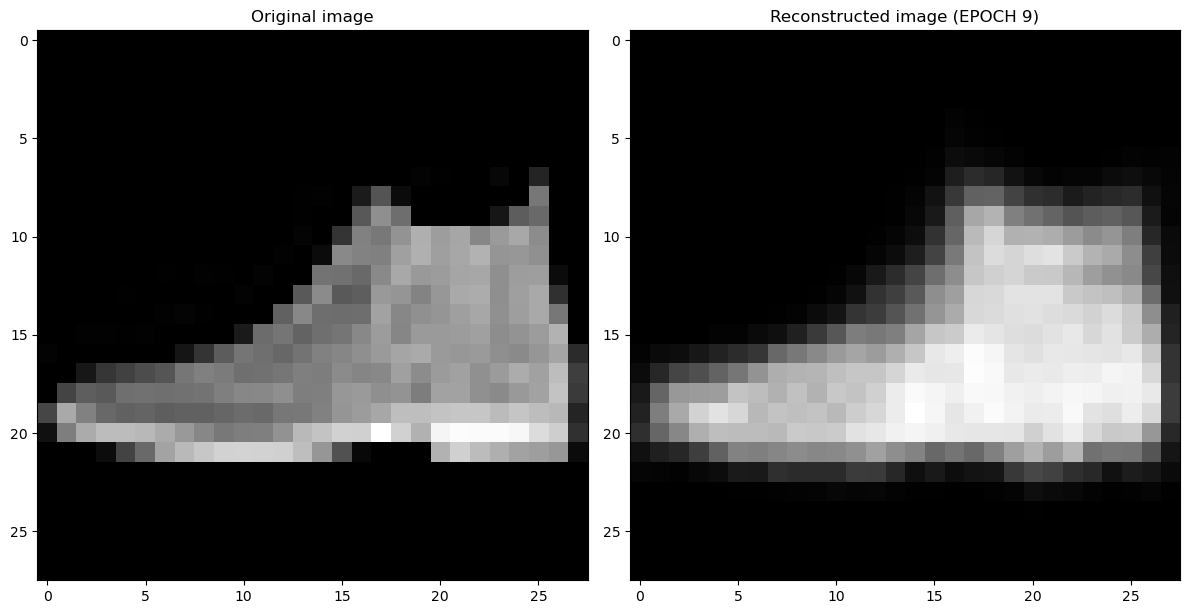

EPOCH 10/10
TRAIN - EPOCH 10/10 - loss: 0.02045588009059429

VALIDATION - EPOCH 10/10 - loss: 0.02042710781097412



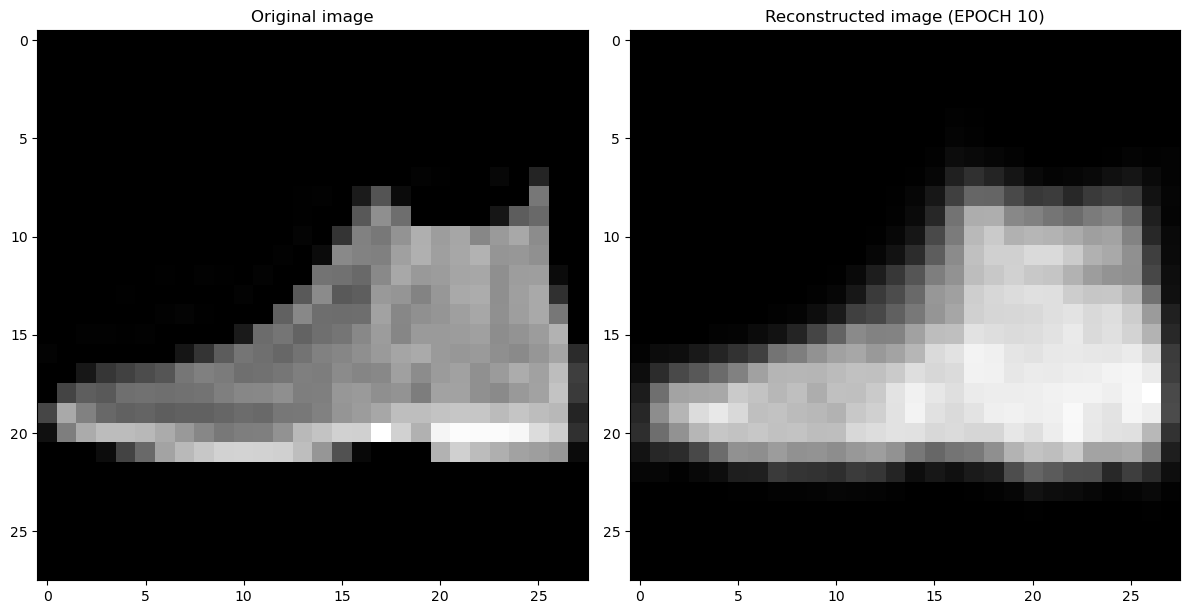

In [24]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 10 # this is the only line we change!
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 5e-4 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

### Training cycle
num_epochs = 10
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    print(f'TRAIN - EPOCH {epoch+1}/{num_epochs} - loss: {train_loss}\n')
    ### Validation (use the testing function)
    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    # Print Validation loss
    print(f'VALIDATION - EPOCH {epoch+1}/{num_epochs} - loss: {val_loss}\n')

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[0][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img = decoder(encoder(img))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

In [25]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:05<00:00, 1785.65it/s]


Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0           72.032280        64.371384       -19.590273       -29.507183   
1           69.888222        15.363521        24.112617       -38.708485   
2           38.889568         9.270471       -16.713919       -96.650444   
3           30.458345        14.479234       -24.372301      -106.229500   
4           56.869698        21.718004         3.917018       -56.966866   
...               ...              ...              ...              ...   
9995        85.710365        57.201981       -10.493038       -24.850706   
9996        30.532368        20.722744       -24.767227      -103.444504   
9997        44.546024         5.964852       -30.080547       -82.519753   
9998        32.857590         7.965837       -27.643866      -104.190544   
9999        63.800297        55.979931       -16.175730       -42.289402   

      Enc. Variable 4  Enc. Variable 5  Enc. Variable 6  Enc. Variable 7  \
0          -27.109617        55.214001       -40.725277        25.771111   
1            4.594518       -15.399539        25.367308       -43.772873   
2           37.897884        12.474517        20.678799        -0.703835   
3           45.298550        11.903986        10.552530         9.842909   
4            2.595989        -0.853669         2.912800       -20.867283   
...               ...              ...              ...              ...   
9995       -65.557327        36.944168       -39.329311         6.169534   
9996        46.593838        17.527891        -0.037485        14.748886   
9997        25.925652         7.018226         6.621729        14.589705   
9998        39.931725        20.375811         7.555325        13.239216   
9999        -2.162097        53.895321       -33.710567        24.031485   

      Enc. Variable 8  Enc. Variable 9  label  
0           66.579361       -53.867558      9  
1            5.436039       -31.293598      2  
2          -37.863567       -34.978851      1  
3          -16.815912       -32.554649      1  
4           17.014013       -23.825031      6  
...               ...              ...    ...  
9995        58.559441       -40.315872      9  
9996        -0.783754       -31.733841      1  
9997        31.092726       -73.511566      8  
9998       -28.934931       -36.401352      1  
9999        49.353313       -49.864643      5  

[10000 rows x 11 columns]

**How can we visualize data?** we like 2D-3D plots for intuition!

PCA and tSNE come into play.

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
encoded_samples_reduced_PCA

array([[101.41821144, -15.79129417],
       [-31.4847845 ,  59.3367361 ],
       [-69.53965022, -36.99391735],
       ...,
       [-17.53316424, -37.40314127],
       [-58.61081824, -59.51383814],
       [ 71.05448458, -28.78700134]])

In [27]:
encoded_samples_reduced_PCA = pd.DataFrame({
    "Enc. Variable 0": encoded_samples_reduced_PCA[:, 0],
    "Enc. Variable 1": encoded_samples_reduced_PCA[:, 1], 
    "label": encoded_samples.label
})
px.scatter(encoded_samples_reduced_PCA, x='Enc. Variable 0', y='Enc. Variable 1', color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)

In [28]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto", perplexity=30)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)
encoded_samples_reduced_TSNE = pd.DataFrame({
    "Enc. Variable 0": encoded_samples_reduced_TSNE[:, 0],
    "Enc. Variable 1": encoded_samples_reduced_TSNE[:, 1], 
    "label": encoded_samples.label
})
px.scatter(encoded_samples_reduced_TSNE, x='Enc. Variable 0', y='Enc. Variable 1', color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)

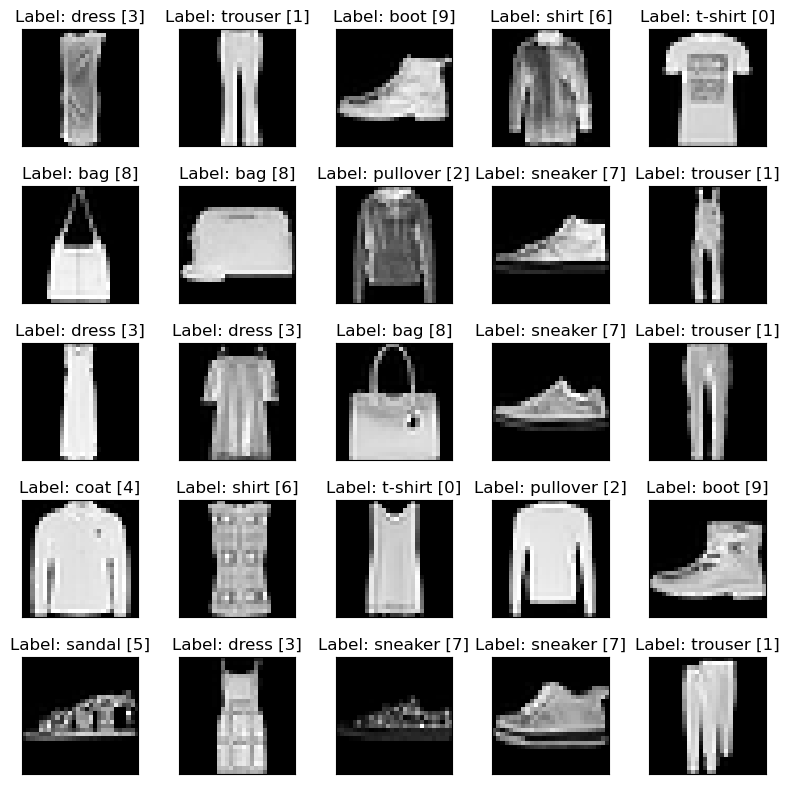

In [29]:
### Plot some samples
label_names = ['t-shirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','boot']
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img.permute(1,2,0).repeat(1, 1, 3)), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

Given a point cloud:
*   **PCA** is like taking a snapshot from a different perspective/angle (linear only)
*   **tSNE** is like taking a snapshot from a different perspective/angle and at the same time stretching the space (non-linear)


# Classification from the latents
Since the latent representations produced by the encoder are usually clustered according to the different classes they can often be used as input to a classifier to solve the classification task. 

Of course it is usually better to simply train the neural network for classification if you have enough labeled data. However since assigning labels to the input samples is often very expensive in some cases you might have partially labeled datasets.

 For this reason you could first train an autoencoder to extract some discriminative features in the data and then train a simpler classifier to take these as input and to predict the class.
 
This task can be usually solved by a simpler model that has lower likelyhood to overfit than a full end-to-end model given the low data availability.

# Simple classifier on the features produced by the encoder

In [30]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

class AEDataset(Dataset):

    def __init__(self, encoder, normal_dataloader, device):
        encoder = encoder.to(device)
        self.x = []
        self.y = []
        self.latents = []
        for x, y in normal_dataloader:
            self.x.append(x)
            self.y.append(y)
            x = x.to(device)
            latents = encoder(x).detach().cpu()
            self.latents.append(latents)
        
        self.x = torch.cat(self.x, axis=0)
        self.y = torch.cat(self.y, axis=0)
        self.latents = torch.cat(self.latents, axis=0)
        self.x, _, self.latents, _, self.y, _ = train_test_split(self.x, self.latents, self.y, train_size=0.01, stratify=self.y)
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.latents[idx],  self.y[idx]

In [31]:
class SimpleClassifier(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.classifier(x)
        return x

In [32]:
from sklearn.metrics import accuracy_score
### Set the random seed for reproducible results
torch.manual_seed(0)

model = SimpleClassifier(encoded_space_dim)
train_dataloader_latents = DataLoader(AEDataset(encoder, train_dataloader, device), batch_size=32, shuffle=True)

### Define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

### Define an optimizer
lr = 5e-4 # Learning rate
optim = torch.optim.Adam(model.parameters(), lr=lr)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
model.to(device)

### Training cycle
num_epochs = 100
val_losses_enc = []
val_accs_enc = []
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    model.train()
    for x, latents, y in tqdm(train_dataloader_latents):
        latents = latents.to(device)
        y = y.to(device)
        y_pred = model(latents)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

    # Set evaluation mode
    model.eval()
    encoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, y in test_dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            y_pred = model(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(y_pred.cpu())
            conc_label.append(y)
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss and accuracy
        val_loss = loss_fn(conc_out, conc_label)
        val_acc = accuracy_score(conc_label, conc_out.softmax(axis=1).argmax(axis=1))
        val_losses_enc.append(val_loss)
        val_accs_enc.append(val_acc)

    print(f'\t VALIDATION - EPOCH {epoch + 1}/{num_epochs} - loss: {val_loss} - acc {val_acc}')

Selected device: cpu
EPOCH 1/100


100%|██████████| 19/19 [00:00<00:00, 520.08it/s]


	 VALIDATION - EPOCH 1/100 - loss: 3.4671242237091064 - acc 0.2921
EPOCH 2/100


100%|██████████| 19/19 [00:00<00:00, 526.78it/s]


	 VALIDATION - EPOCH 2/100 - loss: 1.7745712995529175 - acc 0.4281
EPOCH 3/100


100%|██████████| 19/19 [00:00<00:00, 514.67it/s]


	 VALIDATION - EPOCH 3/100 - loss: 1.2289355993270874 - acc 0.5714
EPOCH 4/100


100%|██████████| 19/19 [00:00<00:00, 319.08it/s]


	 VALIDATION - EPOCH 4/100 - loss: 0.9967508912086487 - acc 0.6383
EPOCH 5/100


100%|██████████| 19/19 [00:00<00:00, 44.77it/s] 


	 VALIDATION - EPOCH 5/100 - loss: 0.9322502017021179 - acc 0.6623
EPOCH 6/100


100%|██████████| 19/19 [00:00<00:00, 534.79it/s]


	 VALIDATION - EPOCH 6/100 - loss: 0.8960312604904175 - acc 0.6781
EPOCH 7/100


100%|██████████| 19/19 [00:00<00:00, 431.62it/s]


	 VALIDATION - EPOCH 7/100 - loss: 0.8837027549743652 - acc 0.6831
EPOCH 8/100


100%|██████████| 19/19 [00:00<00:00, 393.04it/s]


	 VALIDATION - EPOCH 8/100 - loss: 0.8501025438308716 - acc 0.6939
EPOCH 9/100


100%|██████████| 19/19 [00:00<00:00, 55.04it/s]


	 VALIDATION - EPOCH 9/100 - loss: 0.8371310830116272 - acc 0.6984
EPOCH 10/100


100%|██████████| 19/19 [00:00<00:00, 453.79it/s]


	 VALIDATION - EPOCH 10/100 - loss: 0.8265068531036377 - acc 0.707
EPOCH 11/100


100%|██████████| 19/19 [00:00<00:00, 541.02it/s]


	 VALIDATION - EPOCH 11/100 - loss: 0.8205141425132751 - acc 0.7088
EPOCH 12/100


100%|██████████| 19/19 [00:00<00:00, 509.69it/s]


	 VALIDATION - EPOCH 12/100 - loss: 0.8519371151924133 - acc 0.7076
EPOCH 13/100


100%|██████████| 19/19 [00:00<00:00, 544.36it/s]


	 VALIDATION - EPOCH 13/100 - loss: 0.8728690147399902 - acc 0.6744
EPOCH 14/100


100%|██████████| 19/19 [00:00<00:00, 538.94it/s]


	 VALIDATION - EPOCH 14/100 - loss: 0.8183033466339111 - acc 0.7149
EPOCH 15/100


100%|██████████| 19/19 [00:00<00:00, 485.35it/s]


	 VALIDATION - EPOCH 15/100 - loss: 0.8209821581840515 - acc 0.7159
EPOCH 16/100


100%|██████████| 19/19 [00:00<00:00, 545.25it/s]


	 VALIDATION - EPOCH 16/100 - loss: 0.8332818150520325 - acc 0.7014
EPOCH 17/100


100%|██████████| 19/19 [00:00<00:00, 528.72it/s]


	 VALIDATION - EPOCH 17/100 - loss: 0.8029067516326904 - acc 0.7175
EPOCH 18/100


100%|██████████| 19/19 [00:00<00:00, 550.85it/s]


	 VALIDATION - EPOCH 18/100 - loss: 0.8151360154151917 - acc 0.715
EPOCH 19/100


100%|██████████| 19/19 [00:00<00:00, 477.60it/s]


	 VALIDATION - EPOCH 19/100 - loss: 0.8082951307296753 - acc 0.7126
EPOCH 20/100


100%|██████████| 19/19 [00:00<00:00, 496.44it/s]


	 VALIDATION - EPOCH 20/100 - loss: 0.8002468943595886 - acc 0.7178
EPOCH 21/100


100%|██████████| 19/19 [00:00<00:00, 191.71it/s]


	 VALIDATION - EPOCH 21/100 - loss: 0.8023520112037659 - acc 0.7179
EPOCH 22/100


100%|██████████| 19/19 [00:00<00:00, 114.05it/s]


	 VALIDATION - EPOCH 22/100 - loss: 0.7884863615036011 - acc 0.7197
EPOCH 23/100


100%|██████████| 19/19 [00:00<00:00, 637.90it/s]


	 VALIDATION - EPOCH 23/100 - loss: 0.8111363053321838 - acc 0.7092
EPOCH 24/100


100%|██████████| 19/19 [00:00<00:00, 514.69it/s]


	 VALIDATION - EPOCH 24/100 - loss: 0.7963084578514099 - acc 0.7248
EPOCH 25/100


100%|██████████| 19/19 [00:00<00:00, 522.93it/s]


	 VALIDATION - EPOCH 25/100 - loss: 0.8043726086616516 - acc 0.7161
EPOCH 26/100


100%|██████████| 19/19 [00:00<00:00, 483.25it/s]


	 VALIDATION - EPOCH 26/100 - loss: 0.8174599409103394 - acc 0.7087
EPOCH 27/100


100%|██████████| 19/19 [00:00<00:00, 480.27it/s]


	 VALIDATION - EPOCH 27/100 - loss: 0.8026331067085266 - acc 0.7162
EPOCH 28/100


100%|██████████| 19/19 [00:00<00:00, 498.74it/s]


	 VALIDATION - EPOCH 28/100 - loss: 0.794238805770874 - acc 0.7184
EPOCH 29/100


100%|██████████| 19/19 [00:00<00:00, 542.86it/s]


	 VALIDATION - EPOCH 29/100 - loss: 0.7880117297172546 - acc 0.7222
EPOCH 30/100


100%|██████████| 19/19 [00:00<00:00, 500.73it/s]


	 VALIDATION - EPOCH 30/100 - loss: 0.8186846971511841 - acc 0.7089
EPOCH 31/100


100%|██████████| 19/19 [00:00<00:00, 495.01it/s]


	 VALIDATION - EPOCH 31/100 - loss: 0.8258561491966248 - acc 0.7083
EPOCH 32/100


100%|██████████| 19/19 [00:00<00:00, 495.19it/s]


	 VALIDATION - EPOCH 32/100 - loss: 0.7936241030693054 - acc 0.7246
EPOCH 33/100


100%|██████████| 19/19 [00:00<00:00, 526.87it/s]


	 VALIDATION - EPOCH 33/100 - loss: 0.810635507106781 - acc 0.7191
EPOCH 34/100


100%|██████████| 19/19 [00:00<00:00, 397.97it/s]


	 VALIDATION - EPOCH 34/100 - loss: 0.8266483545303345 - acc 0.71
EPOCH 35/100


100%|██████████| 19/19 [00:00<00:00, 483.44it/s]


	 VALIDATION - EPOCH 35/100 - loss: 0.8442875742912292 - acc 0.689
EPOCH 36/100


100%|██████████| 19/19 [00:00<00:00, 457.03it/s]


	 VALIDATION - EPOCH 36/100 - loss: 0.8160479068756104 - acc 0.7132
EPOCH 37/100


100%|██████████| 19/19 [00:00<00:00, 492.95it/s]


	 VALIDATION - EPOCH 37/100 - loss: 0.8313323259353638 - acc 0.7004
EPOCH 38/100


100%|██████████| 19/19 [00:00<00:00, 505.73it/s]


	 VALIDATION - EPOCH 38/100 - loss: 0.8505394458770752 - acc 0.7025
EPOCH 39/100


100%|██████████| 19/19 [00:00<00:00, 557.73it/s]


	 VALIDATION - EPOCH 39/100 - loss: 0.8256955146789551 - acc 0.7159
EPOCH 40/100


100%|██████████| 19/19 [00:00<00:00, 498.93it/s]


	 VALIDATION - EPOCH 40/100 - loss: 0.8038317561149597 - acc 0.7239
EPOCH 41/100


100%|██████████| 19/19 [00:00<00:00, 491.69it/s]


	 VALIDATION - EPOCH 41/100 - loss: 0.8130194544792175 - acc 0.7246
EPOCH 42/100


100%|██████████| 19/19 [00:00<00:00, 529.33it/s]


	 VALIDATION - EPOCH 42/100 - loss: 0.8457748293876648 - acc 0.7021
EPOCH 43/100


100%|██████████| 19/19 [00:00<00:00, 516.59it/s]


	 VALIDATION - EPOCH 43/100 - loss: 0.8355618119239807 - acc 0.7114
EPOCH 44/100


100%|██████████| 19/19 [00:00<00:00, 522.67it/s]


	 VALIDATION - EPOCH 44/100 - loss: 0.8027625679969788 - acc 0.7273
EPOCH 45/100


100%|██████████| 19/19 [00:00<00:00, 127.01it/s]


	 VALIDATION - EPOCH 45/100 - loss: 0.8130340576171875 - acc 0.7288
EPOCH 46/100


100%|██████████| 19/19 [00:00<00:00, 507.41it/s]


	 VALIDATION - EPOCH 46/100 - loss: 0.811148464679718 - acc 0.7221
EPOCH 47/100


100%|██████████| 19/19 [00:00<00:00, 466.37it/s]


	 VALIDATION - EPOCH 47/100 - loss: 0.797055184841156 - acc 0.7279
EPOCH 48/100


100%|██████████| 19/19 [00:00<00:00, 512.81it/s]


	 VALIDATION - EPOCH 48/100 - loss: 0.8165006041526794 - acc 0.7245
EPOCH 49/100


100%|██████████| 19/19 [00:00<00:00, 430.07it/s]


	 VALIDATION - EPOCH 49/100 - loss: 0.8091880679130554 - acc 0.7236
EPOCH 50/100


100%|██████████| 19/19 [00:00<00:00, 520.66it/s]


	 VALIDATION - EPOCH 50/100 - loss: 0.8101557493209839 - acc 0.7225
EPOCH 51/100


100%|██████████| 19/19 [00:00<00:00, 453.54it/s]


	 VALIDATION - EPOCH 51/100 - loss: 0.8132558465003967 - acc 0.7211
EPOCH 52/100


100%|██████████| 19/19 [00:00<00:00, 464.17it/s]


	 VALIDATION - EPOCH 52/100 - loss: 0.795150637626648 - acc 0.7312
EPOCH 53/100


100%|██████████| 19/19 [00:00<00:00, 469.63it/s]


	 VALIDATION - EPOCH 53/100 - loss: 0.8215492963790894 - acc 0.7205
EPOCH 54/100


100%|██████████| 19/19 [00:00<00:00, 480.49it/s]


	 VALIDATION - EPOCH 54/100 - loss: 0.8337631821632385 - acc 0.7062
EPOCH 55/100


100%|██████████| 19/19 [00:00<00:00, 505.13it/s]


	 VALIDATION - EPOCH 55/100 - loss: 0.8307302594184875 - acc 0.7174
EPOCH 56/100


100%|██████████| 19/19 [00:00<00:00, 492.02it/s]


	 VALIDATION - EPOCH 56/100 - loss: 0.8287920951843262 - acc 0.7187
EPOCH 57/100


100%|██████████| 19/19 [00:00<00:00, 529.78it/s]


	 VALIDATION - EPOCH 57/100 - loss: 0.8235712647438049 - acc 0.7243
EPOCH 58/100


100%|██████████| 19/19 [00:00<00:00, 469.58it/s]


	 VALIDATION - EPOCH 58/100 - loss: 0.8423967957496643 - acc 0.7164
EPOCH 59/100


100%|██████████| 19/19 [00:00<00:00, 507.57it/s]


	 VALIDATION - EPOCH 59/100 - loss: 0.8103750348091125 - acc 0.7253
EPOCH 60/100


100%|██████████| 19/19 [00:00<00:00, 508.64it/s]


	 VALIDATION - EPOCH 60/100 - loss: 0.841813862323761 - acc 0.7166
EPOCH 61/100


100%|██████████| 19/19 [00:00<00:00, 534.30it/s]


	 VALIDATION - EPOCH 61/100 - loss: 0.8378690481185913 - acc 0.7117
EPOCH 62/100


100%|██████████| 19/19 [00:00<00:00, 466.72it/s]


	 VALIDATION - EPOCH 62/100 - loss: 0.8390117883682251 - acc 0.7166
EPOCH 63/100


100%|██████████| 19/19 [00:00<00:00, 505.08it/s]


	 VALIDATION - EPOCH 63/100 - loss: 0.8907575011253357 - acc 0.7041
EPOCH 64/100


100%|██████████| 19/19 [00:00<00:00, 477.67it/s]


	 VALIDATION - EPOCH 64/100 - loss: 0.8382863998413086 - acc 0.7208
EPOCH 65/100


100%|██████████| 19/19 [00:00<00:00, 428.71it/s]


	 VALIDATION - EPOCH 65/100 - loss: 0.8242368102073669 - acc 0.7204
EPOCH 66/100


100%|██████████| 19/19 [00:00<00:00, 414.61it/s]


	 VALIDATION - EPOCH 66/100 - loss: 0.8294438719749451 - acc 0.7201
EPOCH 67/100


100%|██████████| 19/19 [00:00<00:00, 454.54it/s]


	 VALIDATION - EPOCH 67/100 - loss: 0.8747051954269409 - acc 0.72
EPOCH 68/100


100%|██████████| 19/19 [00:00<00:00, 478.73it/s]


	 VALIDATION - EPOCH 68/100 - loss: 0.8336065411567688 - acc 0.7251
EPOCH 69/100


100%|██████████| 19/19 [00:00<00:00, 439.12it/s]


	 VALIDATION - EPOCH 69/100 - loss: 0.8457732200622559 - acc 0.7213
EPOCH 70/100


100%|██████████| 19/19 [00:00<00:00, 482.61it/s]


	 VALIDATION - EPOCH 70/100 - loss: 0.8443395495414734 - acc 0.7175
EPOCH 71/100


100%|██████████| 19/19 [00:00<00:00, 482.91it/s]


	 VALIDATION - EPOCH 71/100 - loss: 0.834879994392395 - acc 0.7204
EPOCH 72/100


100%|██████████| 19/19 [00:00<00:00, 471.92it/s]


	 VALIDATION - EPOCH 72/100 - loss: 0.8370271325111389 - acc 0.7248
EPOCH 73/100


100%|██████████| 19/19 [00:00<00:00, 500.74it/s]


	 VALIDATION - EPOCH 73/100 - loss: 0.8462863564491272 - acc 0.7246
EPOCH 74/100


100%|██████████| 19/19 [00:00<00:00, 206.56it/s]


	 VALIDATION - EPOCH 74/100 - loss: 0.8503755927085876 - acc 0.7202
EPOCH 75/100


100%|██████████| 19/19 [00:00<00:00, 520.76it/s]


	 VALIDATION - EPOCH 75/100 - loss: 0.8400817513465881 - acc 0.7265
EPOCH 76/100


100%|██████████| 19/19 [00:00<00:00, 423.06it/s]


	 VALIDATION - EPOCH 76/100 - loss: 0.8449399471282959 - acc 0.7269
EPOCH 77/100


100%|██████████| 19/19 [00:00<00:00, 484.83it/s]


	 VALIDATION - EPOCH 77/100 - loss: 0.8454699516296387 - acc 0.7246
EPOCH 78/100


100%|██████████| 19/19 [00:00<00:00, 445.19it/s]


	 VALIDATION - EPOCH 78/100 - loss: 0.8635978698730469 - acc 0.7229
EPOCH 79/100


100%|██████████| 19/19 [00:00<00:00, 485.12it/s]


	 VALIDATION - EPOCH 79/100 - loss: 0.8536032438278198 - acc 0.7182
EPOCH 80/100


100%|██████████| 19/19 [00:00<00:00, 475.26it/s]


	 VALIDATION - EPOCH 80/100 - loss: 0.8620423078536987 - acc 0.7154
EPOCH 81/100


100%|██████████| 19/19 [00:00<00:00, 451.75it/s]


	 VALIDATION - EPOCH 81/100 - loss: 0.8893163204193115 - acc 0.7057
EPOCH 82/100


100%|██████████| 19/19 [00:00<00:00, 489.30it/s]


	 VALIDATION - EPOCH 82/100 - loss: 0.8825508952140808 - acc 0.7146
EPOCH 83/100


100%|██████████| 19/19 [00:00<00:00, 491.86it/s]


	 VALIDATION - EPOCH 83/100 - loss: 0.8596347570419312 - acc 0.7242
EPOCH 84/100


100%|██████████| 19/19 [00:00<00:00, 465.35it/s]


	 VALIDATION - EPOCH 84/100 - loss: 0.8711440563201904 - acc 0.7202
EPOCH 85/100


100%|██████████| 19/19 [00:00<00:00, 551.47it/s]


	 VALIDATION - EPOCH 85/100 - loss: 0.8964071273803711 - acc 0.7255
EPOCH 86/100


100%|██████████| 19/19 [00:00<00:00, 415.08it/s]


	 VALIDATION - EPOCH 86/100 - loss: 0.8833616375923157 - acc 0.7156
EPOCH 87/100


100%|██████████| 19/19 [00:00<00:00, 521.35it/s]


	 VALIDATION - EPOCH 87/100 - loss: 0.9010235071182251 - acc 0.7155
EPOCH 88/100


100%|██████████| 19/19 [00:00<00:00, 429.29it/s]


	 VALIDATION - EPOCH 88/100 - loss: 0.8896315693855286 - acc 0.7127
EPOCH 89/100


100%|██████████| 19/19 [00:00<00:00, 489.85it/s]


	 VALIDATION - EPOCH 89/100 - loss: 0.8694181442260742 - acc 0.7201
EPOCH 90/100


100%|██████████| 19/19 [00:00<00:00, 374.46it/s]


	 VALIDATION - EPOCH 90/100 - loss: 0.8739092946052551 - acc 0.7276
EPOCH 91/100


100%|██████████| 19/19 [00:00<00:00, 423.14it/s]


	 VALIDATION - EPOCH 91/100 - loss: 0.870629072189331 - acc 0.7216
EPOCH 92/100


100%|██████████| 19/19 [00:00<00:00, 482.08it/s]


	 VALIDATION - EPOCH 92/100 - loss: 0.8716277480125427 - acc 0.7262
EPOCH 93/100


100%|██████████| 19/19 [00:00<00:00, 446.01it/s]


	 VALIDATION - EPOCH 93/100 - loss: 0.9099794030189514 - acc 0.7172
EPOCH 94/100


100%|██████████| 19/19 [00:00<00:00, 488.36it/s]


	 VALIDATION - EPOCH 94/100 - loss: 0.8884028196334839 - acc 0.7219
EPOCH 95/100


100%|██████████| 19/19 [00:00<00:00, 479.35it/s]


	 VALIDATION - EPOCH 95/100 - loss: 0.8867905139923096 - acc 0.72
EPOCH 96/100


100%|██████████| 19/19 [00:00<00:00, 465.00it/s]


	 VALIDATION - EPOCH 96/100 - loss: 0.8827364444732666 - acc 0.7235
EPOCH 97/100


100%|██████████| 19/19 [00:00<00:00, 411.44it/s]


	 VALIDATION - EPOCH 97/100 - loss: 0.8977586627006531 - acc 0.7233
EPOCH 98/100


100%|██████████| 19/19 [00:00<00:00, 473.99it/s]


	 VALIDATION - EPOCH 98/100 - loss: 0.8861741423606873 - acc 0.7216
EPOCH 99/100


100%|██████████| 19/19 [00:00<00:00, 470.13it/s]


	 VALIDATION - EPOCH 99/100 - loss: 0.8936321139335632 - acc 0.7203
EPOCH 100/100


100%|██████████| 19/19 [00:00<00:00, 450.89it/s]


	 VALIDATION - EPOCH 100/100 - loss: 0.8802688717842102 - acc 0.7285


In [33]:
class FullClassifier(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=3*3*32, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=encoded_space_dim)
        )
        self.classifier = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        x = self.classifier(x)
        return x

In [34]:
### Set the random seed for reproducible results
torch.manual_seed(0)

model = FullClassifier(encoded_space_dim)

### Define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

### Define an optimizer
lr = 5e-4 # Learning rate
optim = torch.optim.Adam(model.parameters(), lr=lr)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

model.to(device)

### Training cycle
num_epochs = 100
val_losses_full = []
val_accs_full = []
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    model.train()
    for x, _, y in tqdm(train_dataloader_latents):
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

    # Set evaluation mode
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, y in test_dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Perform prediction
            y_pred = model(image_batch)
            # Append the network output and the labels to the lists
            conc_out.append(y_pred.cpu())
            conc_label.append(y)
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss and accuracy
        val_loss = loss_fn(conc_out, conc_label)
        val_acc = accuracy_score(conc_label, conc_out.softmax(axis=1).argmax(axis=1))
        val_losses_full.append(val_loss)
        val_accs_full.append(val_acc)
    ### Training (use the training function)
    print(f'\t VALIDATION - EPOCH {epoch + 1}/{num_epochs} - loss: {val_loss} - acc {val_acc}')

Selected device: cpu
EPOCH 1/100


100%|██████████| 19/19 [00:00<00:00, 141.39it/s]


	 VALIDATION - EPOCH 1/100 - loss: 2.300896644592285 - acc 0.1
EPOCH 2/100


100%|██████████| 19/19 [00:00<00:00, 214.39it/s]


	 VALIDATION - EPOCH 2/100 - loss: 2.2721588611602783 - acc 0.209
EPOCH 3/100


100%|██████████| 19/19 [00:00<00:00, 218.95it/s]


	 VALIDATION - EPOCH 3/100 - loss: 2.0818867683410645 - acc 0.2352
EPOCH 4/100


100%|██████████| 19/19 [00:00<00:00, 218.48it/s]


	 VALIDATION - EPOCH 4/100 - loss: 1.6035562753677368 - acc 0.3412
EPOCH 5/100


100%|██████████| 19/19 [00:00<00:00, 208.31it/s]


	 VALIDATION - EPOCH 5/100 - loss: 1.192460536956787 - acc 0.5036
EPOCH 6/100


100%|██████████| 19/19 [00:00<00:00, 176.22it/s]


	 VALIDATION - EPOCH 6/100 - loss: 1.0928417444229126 - acc 0.5275
EPOCH 7/100


100%|██████████| 19/19 [00:00<00:00, 171.67it/s]


	 VALIDATION - EPOCH 7/100 - loss: 1.0562814474105835 - acc 0.5736
EPOCH 8/100


100%|██████████| 19/19 [00:00<00:00, 223.71it/s]


	 VALIDATION - EPOCH 8/100 - loss: 1.0524637699127197 - acc 0.5584
EPOCH 9/100


100%|██████████| 19/19 [00:00<00:00, 219.67it/s]


	 VALIDATION - EPOCH 9/100 - loss: 0.9700695276260376 - acc 0.6139
EPOCH 10/100


100%|██████████| 19/19 [00:00<00:00, 216.06it/s]


	 VALIDATION - EPOCH 10/100 - loss: 0.9508338570594788 - acc 0.6163
EPOCH 11/100


100%|██████████| 19/19 [00:00<00:00, 216.37it/s]


	 VALIDATION - EPOCH 11/100 - loss: 0.918404221534729 - acc 0.6349
EPOCH 12/100


100%|██████████| 19/19 [00:00<00:00, 185.64it/s]


	 VALIDATION - EPOCH 12/100 - loss: 0.9017297625541687 - acc 0.6412
EPOCH 13/100


100%|██████████| 19/19 [00:00<00:00, 207.23it/s]


	 VALIDATION - EPOCH 13/100 - loss: 0.9296679496765137 - acc 0.6372
EPOCH 14/100


100%|██████████| 19/19 [00:00<00:00, 208.25it/s]


	 VALIDATION - EPOCH 14/100 - loss: 1.0074669122695923 - acc 0.6278
EPOCH 15/100


100%|██████████| 19/19 [00:00<00:00, 222.91it/s]


	 VALIDATION - EPOCH 15/100 - loss: 0.9570462107658386 - acc 0.6433
EPOCH 16/100


100%|██████████| 19/19 [00:00<00:00, 210.96it/s]


	 VALIDATION - EPOCH 16/100 - loss: 0.8615580797195435 - acc 0.6842
EPOCH 17/100


100%|██████████| 19/19 [00:00<00:00, 205.04it/s]


	 VALIDATION - EPOCH 17/100 - loss: 0.8805864453315735 - acc 0.6849
EPOCH 18/100


100%|██████████| 19/19 [00:00<00:00, 215.08it/s]


	 VALIDATION - EPOCH 18/100 - loss: 0.8935525417327881 - acc 0.6501
EPOCH 19/100


100%|██████████| 19/19 [00:00<00:00, 202.71it/s]


	 VALIDATION - EPOCH 19/100 - loss: 0.848332405090332 - acc 0.683
EPOCH 20/100


100%|██████████| 19/19 [00:00<00:00, 198.39it/s]


	 VALIDATION - EPOCH 20/100 - loss: 0.8398247361183167 - acc 0.679
EPOCH 21/100


100%|██████████| 19/19 [00:00<00:00, 199.13it/s]


	 VALIDATION - EPOCH 21/100 - loss: 0.8626154065132141 - acc 0.6793
EPOCH 22/100


100%|██████████| 19/19 [00:00<00:00, 195.96it/s]


	 VALIDATION - EPOCH 22/100 - loss: 0.8713666796684265 - acc 0.6743
EPOCH 23/100


100%|██████████| 19/19 [00:00<00:00, 206.95it/s]


	 VALIDATION - EPOCH 23/100 - loss: 0.8270784020423889 - acc 0.696
EPOCH 24/100


100%|██████████| 19/19 [00:00<00:00, 214.25it/s]


	 VALIDATION - EPOCH 24/100 - loss: 0.8586607575416565 - acc 0.6827
EPOCH 25/100


100%|██████████| 19/19 [00:00<00:00, 221.86it/s]


	 VALIDATION - EPOCH 25/100 - loss: 0.8478190302848816 - acc 0.6876
EPOCH 26/100


100%|██████████| 19/19 [00:00<00:00, 219.14it/s]


	 VALIDATION - EPOCH 26/100 - loss: 0.8464167714118958 - acc 0.7073
EPOCH 27/100


100%|██████████| 19/19 [00:00<00:00, 212.60it/s]


	 VALIDATION - EPOCH 27/100 - loss: 0.9129533171653748 - acc 0.6733
EPOCH 28/100


100%|██████████| 19/19 [00:00<00:00, 208.13it/s]


	 VALIDATION - EPOCH 28/100 - loss: 0.825799822807312 - acc 0.7082
EPOCH 29/100


100%|██████████| 19/19 [00:00<00:00, 231.25it/s]


	 VALIDATION - EPOCH 29/100 - loss: 0.8561660051345825 - acc 0.7004
EPOCH 30/100


100%|██████████| 19/19 [00:00<00:00, 209.66it/s]


	 VALIDATION - EPOCH 30/100 - loss: 0.8052721619606018 - acc 0.7115
EPOCH 31/100


100%|██████████| 19/19 [00:00<00:00, 213.79it/s]


	 VALIDATION - EPOCH 31/100 - loss: 0.8252013921737671 - acc 0.6984
EPOCH 32/100


100%|██████████| 19/19 [00:00<00:00, 210.65it/s]


	 VALIDATION - EPOCH 32/100 - loss: 0.8329737186431885 - acc 0.7203
EPOCH 33/100


100%|██████████| 19/19 [00:00<00:00, 206.51it/s]


	 VALIDATION - EPOCH 33/100 - loss: 0.879661500453949 - acc 0.707
EPOCH 34/100


100%|██████████| 19/19 [00:00<00:00, 197.86it/s]


	 VALIDATION - EPOCH 34/100 - loss: 0.8241578340530396 - acc 0.7211
EPOCH 35/100


100%|██████████| 19/19 [00:00<00:00, 210.37it/s]


	 VALIDATION - EPOCH 35/100 - loss: 0.8149920701980591 - acc 0.7166
EPOCH 36/100


100%|██████████| 19/19 [00:00<00:00, 209.49it/s]


	 VALIDATION - EPOCH 36/100 - loss: 0.8317437767982483 - acc 0.7167
EPOCH 37/100


100%|██████████| 19/19 [00:00<00:00, 207.99it/s]


	 VALIDATION - EPOCH 37/100 - loss: 0.7981504201889038 - acc 0.7302
EPOCH 38/100


100%|██████████| 19/19 [00:00<00:00, 207.76it/s]


	 VALIDATION - EPOCH 38/100 - loss: 0.7948789596557617 - acc 0.7267
EPOCH 39/100


100%|██████████| 19/19 [00:00<00:00, 207.91it/s]


	 VALIDATION - EPOCH 39/100 - loss: 0.8493742346763611 - acc 0.7204
EPOCH 40/100


100%|██████████| 19/19 [00:00<00:00, 208.80it/s]


	 VALIDATION - EPOCH 40/100 - loss: 0.842430830001831 - acc 0.7181
EPOCH 41/100


100%|██████████| 19/19 [00:00<00:00, 212.80it/s]


	 VALIDATION - EPOCH 41/100 - loss: 0.7865924835205078 - acc 0.7346
EPOCH 42/100


100%|██████████| 19/19 [00:00<00:00, 217.56it/s]


	 VALIDATION - EPOCH 42/100 - loss: 0.7947524189949036 - acc 0.7308
EPOCH 43/100


100%|██████████| 19/19 [00:00<00:00, 205.54it/s]


	 VALIDATION - EPOCH 43/100 - loss: 0.8004710078239441 - acc 0.7382
EPOCH 44/100


100%|██████████| 19/19 [00:00<00:00, 218.41it/s]


	 VALIDATION - EPOCH 44/100 - loss: 0.8205824494361877 - acc 0.7309
EPOCH 45/100


100%|██████████| 19/19 [00:00<00:00, 201.32it/s]


	 VALIDATION - EPOCH 45/100 - loss: 0.8045118451118469 - acc 0.7355
EPOCH 46/100


100%|██████████| 19/19 [00:00<00:00, 210.51it/s]


	 VALIDATION - EPOCH 46/100 - loss: 0.7982659935951233 - acc 0.7277
EPOCH 47/100


100%|██████████| 19/19 [00:00<00:00, 211.11it/s]


	 VALIDATION - EPOCH 47/100 - loss: 0.8176986575126648 - acc 0.73
EPOCH 48/100


100%|██████████| 19/19 [00:00<00:00, 201.21it/s]


	 VALIDATION - EPOCH 48/100 - loss: 0.8266791105270386 - acc 0.7336
EPOCH 49/100


100%|██████████| 19/19 [00:00<00:00, 205.30it/s]


	 VALIDATION - EPOCH 49/100 - loss: 0.8001613020896912 - acc 0.7384
EPOCH 50/100


100%|██████████| 19/19 [00:00<00:00, 202.99it/s]


	 VALIDATION - EPOCH 50/100 - loss: 0.7765503525733948 - acc 0.7416
EPOCH 51/100


100%|██████████| 19/19 [00:00<00:00, 204.11it/s]


	 VALIDATION - EPOCH 51/100 - loss: 0.8320122361183167 - acc 0.7154
EPOCH 52/100


100%|██████████| 19/19 [00:00<00:00, 198.99it/s]


	 VALIDATION - EPOCH 52/100 - loss: 0.8233232498168945 - acc 0.7352
EPOCH 53/100


100%|██████████| 19/19 [00:00<00:00, 205.95it/s]


	 VALIDATION - EPOCH 53/100 - loss: 0.8108432292938232 - acc 0.7373
EPOCH 54/100


100%|██████████| 19/19 [00:00<00:00, 208.51it/s]


	 VALIDATION - EPOCH 54/100 - loss: 0.8104336857795715 - acc 0.7368
EPOCH 55/100


100%|██████████| 19/19 [00:00<00:00, 192.60it/s]


	 VALIDATION - EPOCH 55/100 - loss: 0.8097456693649292 - acc 0.7434
EPOCH 56/100


100%|██████████| 19/19 [00:00<00:00, 204.12it/s]


	 VALIDATION - EPOCH 56/100 - loss: 0.7934039831161499 - acc 0.745
EPOCH 57/100


100%|██████████| 19/19 [00:00<00:00, 206.76it/s]


	 VALIDATION - EPOCH 57/100 - loss: 0.8407144546508789 - acc 0.7328
EPOCH 58/100


100%|██████████| 19/19 [00:00<00:00, 198.50it/s]


	 VALIDATION - EPOCH 58/100 - loss: 0.8394856452941895 - acc 0.7359
EPOCH 59/100


100%|██████████| 19/19 [00:00<00:00, 204.53it/s]


	 VALIDATION - EPOCH 59/100 - loss: 0.8640846610069275 - acc 0.7286
EPOCH 60/100


100%|██████████| 19/19 [00:00<00:00, 214.90it/s]


	 VALIDATION - EPOCH 60/100 - loss: 0.8628065586090088 - acc 0.7207
EPOCH 61/100


100%|██████████| 19/19 [00:00<00:00, 116.53it/s]


	 VALIDATION - EPOCH 61/100 - loss: 0.7773656249046326 - acc 0.7463
EPOCH 62/100


100%|██████████| 19/19 [00:00<00:00, 208.52it/s]


	 VALIDATION - EPOCH 62/100 - loss: 0.7844048142433167 - acc 0.7478
EPOCH 63/100


100%|██████████| 19/19 [00:00<00:00, 211.74it/s]


	 VALIDATION - EPOCH 63/100 - loss: 0.7853617072105408 - acc 0.7518
EPOCH 64/100


100%|██████████| 19/19 [00:00<00:00, 209.61it/s]


	 VALIDATION - EPOCH 64/100 - loss: 0.8621772527694702 - acc 0.7326
EPOCH 65/100


100%|██████████| 19/19 [00:00<00:00, 195.56it/s]


	 VALIDATION - EPOCH 65/100 - loss: 0.8222468495368958 - acc 0.737
EPOCH 66/100


100%|██████████| 19/19 [00:00<00:00, 196.07it/s]


	 VALIDATION - EPOCH 66/100 - loss: 0.8411880731582642 - acc 0.7287
EPOCH 67/100


100%|██████████| 19/19 [00:00<00:00, 202.26it/s]


	 VALIDATION - EPOCH 67/100 - loss: 0.8196909427642822 - acc 0.7435
EPOCH 68/100


100%|██████████| 19/19 [00:00<00:00, 202.94it/s]


	 VALIDATION - EPOCH 68/100 - loss: 0.821160078048706 - acc 0.7437
EPOCH 69/100


100%|██████████| 19/19 [00:00<00:00, 200.49it/s]


	 VALIDATION - EPOCH 69/100 - loss: 0.8581353425979614 - acc 0.732
EPOCH 70/100


100%|██████████| 19/19 [00:00<00:00, 199.70it/s]


	 VALIDATION - EPOCH 70/100 - loss: 0.8167218565940857 - acc 0.7483
EPOCH 71/100


100%|██████████| 19/19 [00:00<00:00, 171.46it/s]


	 VALIDATION - EPOCH 71/100 - loss: 0.8112691640853882 - acc 0.7437
EPOCH 72/100


100%|██████████| 19/19 [00:00<00:00, 212.71it/s]


	 VALIDATION - EPOCH 72/100 - loss: 0.8010020852088928 - acc 0.7522
EPOCH 73/100


100%|██████████| 19/19 [00:00<00:00, 209.62it/s]


	 VALIDATION - EPOCH 73/100 - loss: 0.8807400465011597 - acc 0.7379
EPOCH 74/100


100%|██████████| 19/19 [00:00<00:00, 202.40it/s]


	 VALIDATION - EPOCH 74/100 - loss: 0.8843337893486023 - acc 0.7303
EPOCH 75/100


100%|██████████| 19/19 [00:00<00:00, 204.97it/s]


	 VALIDATION - EPOCH 75/100 - loss: 0.8847904205322266 - acc 0.7306
EPOCH 76/100


100%|██████████| 19/19 [00:00<00:00, 199.80it/s]


	 VALIDATION - EPOCH 76/100 - loss: 0.8717743158340454 - acc 0.7306
EPOCH 77/100


100%|██████████| 19/19 [00:00<00:00, 212.56it/s]


	 VALIDATION - EPOCH 77/100 - loss: 0.8153625726699829 - acc 0.7557
EPOCH 78/100


100%|██████████| 19/19 [00:00<00:00, 207.75it/s]


	 VALIDATION - EPOCH 78/100 - loss: 0.8707833886146545 - acc 0.7464
EPOCH 79/100


100%|██████████| 19/19 [00:00<00:00, 191.75it/s]


	 VALIDATION - EPOCH 79/100 - loss: 0.8511523604393005 - acc 0.7482
EPOCH 80/100


100%|██████████| 19/19 [00:00<00:00, 199.54it/s]


	 VALIDATION - EPOCH 80/100 - loss: 0.8099203705787659 - acc 0.7549
EPOCH 81/100


100%|██████████| 19/19 [00:00<00:00, 185.20it/s]


	 VALIDATION - EPOCH 81/100 - loss: 0.8470450043678284 - acc 0.752
EPOCH 82/100


100%|██████████| 19/19 [00:00<00:00, 191.94it/s]


	 VALIDATION - EPOCH 82/100 - loss: 0.8122254610061646 - acc 0.7538
EPOCH 83/100


100%|██████████| 19/19 [00:00<00:00, 201.79it/s]


	 VALIDATION - EPOCH 83/100 - loss: 0.8445419073104858 - acc 0.7482
EPOCH 84/100


100%|██████████| 19/19 [00:00<00:00, 194.69it/s]


	 VALIDATION - EPOCH 84/100 - loss: 0.8801751136779785 - acc 0.7468
EPOCH 85/100


100%|██████████| 19/19 [00:00<00:00, 195.02it/s]


	 VALIDATION - EPOCH 85/100 - loss: 0.875702440738678 - acc 0.7474
EPOCH 86/100


100%|██████████| 19/19 [00:00<00:00, 198.27it/s]


	 VALIDATION - EPOCH 86/100 - loss: 0.9141740202903748 - acc 0.739
EPOCH 87/100


100%|██████████| 19/19 [00:00<00:00, 204.70it/s]


	 VALIDATION - EPOCH 87/100 - loss: 0.8707656264305115 - acc 0.7389
EPOCH 88/100


100%|██████████| 19/19 [00:00<00:00, 207.33it/s]


	 VALIDATION - EPOCH 88/100 - loss: 0.9171586036682129 - acc 0.7282
EPOCH 89/100


100%|██████████| 19/19 [00:00<00:00, 200.11it/s]


	 VALIDATION - EPOCH 89/100 - loss: 0.8577042818069458 - acc 0.7523
EPOCH 90/100


100%|██████████| 19/19 [00:00<00:00, 200.71it/s]


	 VALIDATION - EPOCH 90/100 - loss: 0.8814371228218079 - acc 0.7479
EPOCH 91/100


100%|██████████| 19/19 [00:00<00:00, 200.22it/s]


	 VALIDATION - EPOCH 91/100 - loss: 0.8722376823425293 - acc 0.7423
EPOCH 92/100


100%|██████████| 19/19 [00:00<00:00, 192.17it/s]


	 VALIDATION - EPOCH 92/100 - loss: 0.8968790173530579 - acc 0.7459
EPOCH 93/100


100%|██████████| 19/19 [00:00<00:00, 196.01it/s]


	 VALIDATION - EPOCH 93/100 - loss: 0.9012813568115234 - acc 0.7469
EPOCH 94/100


100%|██████████| 19/19 [00:00<00:00, 182.90it/s]


	 VALIDATION - EPOCH 94/100 - loss: 0.8530258536338806 - acc 0.7616
EPOCH 95/100


100%|██████████| 19/19 [00:00<00:00, 146.72it/s]


	 VALIDATION - EPOCH 95/100 - loss: 0.8636173605918884 - acc 0.754
EPOCH 96/100


100%|██████████| 19/19 [00:00<00:00, 193.88it/s]


	 VALIDATION - EPOCH 96/100 - loss: 0.9020617008209229 - acc 0.7545
EPOCH 97/100


100%|██████████| 19/19 [00:00<00:00, 119.75it/s]


	 VALIDATION - EPOCH 97/100 - loss: 0.8834173083305359 - acc 0.758
EPOCH 98/100


100%|██████████| 19/19 [00:00<00:00, 206.37it/s]


	 VALIDATION - EPOCH 98/100 - loss: 0.9739879965782166 - acc 0.736
EPOCH 99/100


100%|██████████| 19/19 [00:00<00:00, 195.54it/s]


	 VALIDATION - EPOCH 99/100 - loss: 0.8592881560325623 - acc 0.7627
EPOCH 100/100


100%|██████████| 19/19 [00:00<00:00, 202.10it/s]


	 VALIDATION - EPOCH 100/100 - loss: 0.913364827632904 - acc 0.7526


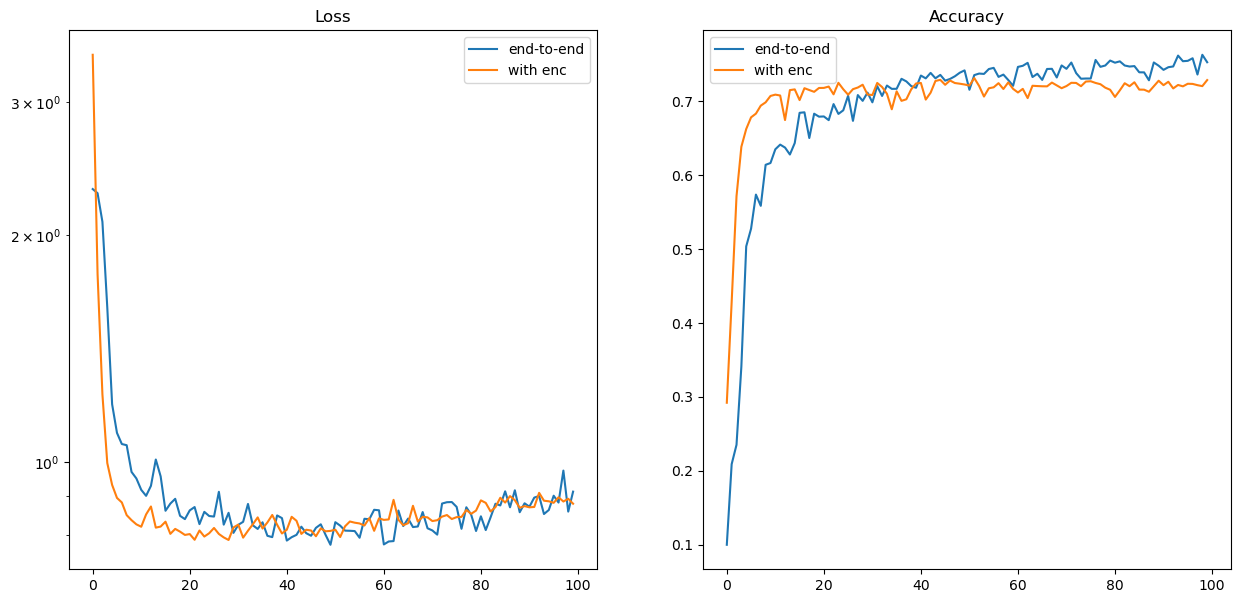

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].plot(val_losses_full, label="end-to-end")
axs[0].plot(val_losses_enc, label="with enc")
axs[0].set_yscale("log")
axs[0].set_title("Loss")
axs[0].legend()

axs[1].plot(val_accs_full, label="end-to-end")
axs[1].plot(val_accs_enc, label="with enc")
axs[1].set_title("Accuracy")
axs[1].legend()

plt.show()

**Autoencoders** can be used to solve a variety of different tasks!


*   Denoising images: add random noise to the training transform and want to predict the denoised image
*   Filling holes: add random holes in the image and predict the filled image
*   Image Generation: via Variational Autoencoders (VAEs), ...

